<a href="https://colab.research.google.com/github/angiegh2002/capital-bike-diaries/blob/main/DM_Homeworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital Bike Share Diaries: Data Mining Project

## 1. Introduction

### 1.1. Project Overview
* Briefly describe the project's goal (analyzing daily bike trips in Washington D.C.).

### 1.2. Objectives
* List the main objectives as stated in the document (understanding usage patterns, weather impact, high activity zones, etc.).

### 1.3. Datasets
* List the datasets to be used (Daily Bikes Trips, Daily Weather Info, Stations Info, etc.).

### 1.4. Tools and Libraries
* Mention the programming language (Python) and permitted frameworks (Pandas, NumPy, Plotly, Scikit-Learn, etc.).

## 2. Setup Environment

#### 2.0.1 Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### 2.0.2 Installing Libraries

In [ ]:
%%capture
!pip install geopandas
!pip install -U shapely pyproj rtree
!pip install pygeohash
!pip install missingno
!pip install folium
!pip install -U kaleido

### 2.1. Import Libraries

In [2]:
# Import necessary libraries
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import folium
import pygeohash
import missingno as msno
from scipy import stats
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import datetime
import math

import pygeohash as pgh
from shapely.geometry import box


ModuleNotFoundError: No module named 'pygeohash'

### 2.2. Load Datasets
* Load each dataset into pandas/geopandas DataFrames.
* Display the head and info for each dataset to get a first look.

In [17]:
data_folder_path = "/content/drive/MyDrive/Data Mining Homework/Homework 01/data"

# List the files in the data folder
files = [f for f in os.listdir(data_folder_path) if os.path.isfile(os.path.join(data_folder_path, f))]

# Create a dictionary to store dataframes
dataframes = {}

# Load each file into a pandas DataFrame
for file_name in files:
    file_path = os.path.join(data_folder_path, file_name)
    try:
        df_name = os.path.splitext(file_name)[0] # Use filename without extension as dataframe key
        if file_name.endswith('.csv'):
            dataframes[df_name] = pd.read_csv(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.parquet'):
            dataframes[df_name] = pd.read_parquet(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.geojson'):
            # You might need to install geopandas: pip install geopandas
            dataframes[df_name] = gpd.read_file(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        else:
            print(f"Skipping unknown file type: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

Successfully loaded DDOT_Central_Business_District.geojson into dataframe 'DDOT_Central_Business_District'
Successfully loaded Residential_and_Visitor_Parking_Zones.geojson into dataframe 'Residential_and_Visitor_Parking_Zones'
Successfully loaded Capital_Bikeshare_Locations.csv into dataframe 'Capital_Bikeshare_Locations'
Successfully loaded Washington,DC,USA 2024-01-01 to 2024-12-31.csv into dataframe 'Washington,DC,USA 2024-01-01 to 2024-12-31'
Successfully loaded Metro_Bus_Stops.csv into dataframe 'Metro_Bus_Stops'
Successfully loaded Shuttle_Bus_Stops.csv into dataframe 'Shuttle_Bus_Stops'
Successfully loaded stations.csv into dataframe 'stations'
Successfully loaded daily-rent-sampled.parquet into dataframe 'daily-rent-sampled'
Successfully loaded daily-rent.parquet into dataframe 'daily-rent'


Data Frames names:
- Daily Bikes Trips
- Daily Weather Info
- Stations Info Dataset
- Stations Table
- CBD Polygon
- Metro Bus Stops
- Shuttle Bus Stops
- Residential and Visitor Parking Zones

In [18]:
stations_info_df = dataframes['Capital_Bikeshare_Locations']
metro_bus_stops_df = dataframes['Metro_Bus_Stops']
shuttle_bus_stops_df = dataframes['Shuttle_Bus_Stops']
daily_weather_info_df = dataframes['Washington,DC,USA 2024-01-01 to 2024-12-31']
daily_bikes_trips_all_df=dataframes['daily-rent']
daily_bikes_trips_df=dataframes['daily-rent-sampled']
stations_table_df = dataframes['stations']
cbd_polygon_df = dataframes['DDOT_Central_Business_District']
residential_and_visitor_parking_zones_df = dataframes['Residential_and_Visitor_Parking_Zones']

## 3. Data Cleaning and Integration (Preprocessing)

### 3.1. Initial Data Inspection
* Check for missing values (`.isnull().sum()`).
* Check data types (`.dtypes`).
* Check for duplicates (`.duplicated().sum()`).
* Basic descriptive statistics (`.describe(include='all')`).

##### 3.1.1 For Daily Bikes Trips


###### Data Info

In [19]:
daily_bikes_trips_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,38.879819,-77.037413,casual
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,38.897283,-77.022191,casual
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,38.876823,-77.017774,casual
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,38.878433,-77.030230,casual
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,38.898164,-77.031898,casual


In [20]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018456 entries, 0 to 2018455
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 200.2+ MB


In [21]:
daily_bikes_trips_df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
count,2018456,2018456,2018456,2018456,1625166,1625166,1609820,1609289,2.018456e+06,2.018456e+06,2.016904e+06,2.016904e+06,2018456
unique,2018430,2,NaN,NaN,816,802,814,800,NaN,NaN,NaN,NaN,2
top,071841FB4E2FFDBB,electric_bike,NaN,NaN,Columbus Circle / Union Station,31623,Columbus Circle / Union Station,31623,NaN,NaN,NaN,NaN,member
freq,2,1123975,NaN,NaN,18016,18016,18249,18243,NaN,NaN,NaN,NaN,1339915
mean,NaN,NaN,2024-07-18 17:20:21.606335488,2024-07-18 18:32:57.616510208,NaN,NaN,NaN,NaN,3.890581e+01,-7.703182e+01,3.890509e+01,-7.703160e+01,NaN
min,NaN,NaN,1970-01-01 00:00:00,2000-01-01 15:55:56,NaN,NaN,NaN,NaN,0.000000e+00,-7.739000e+01,0.000000e+00,-8.018000e+01,NaN
25%,NaN,NaN,2024-05-03 10:31:50.249999872,2024-05-03 10:53:36.750000128,NaN,NaN,NaN,NaN,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01,NaN
50%,NaN,NaN,2024-07-26 11:24:29.612000,2024-07-26 11:42:10.036499968,NaN,NaN,NaN,NaN,3.890543e+01,-7.703000e+01,3.890383e+01,-7.703000e+01,NaN
75%,NaN,NaN,2024-10-06 17:19:02.340999936,2024-10-06 17:40:53.261750016,NaN,NaN,NaN,NaN,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01,NaN
max,NaN,NaN,2024-12-31 23:54:29.513000,2030-01-01 00:00:00,NaN,NaN,NaN,NaN,3.914000e+01,0.000000e+00,4.217000e+01,0.000000e+00,NaN


###### Unique Values

In [22]:
daily_bikes_trips_df.nunique()

,0
ride_id,2018430
rideable_type,2
started_at,1989352
ended_at,1989525
start_station_name,816
start_station_id,802
end_station_name,814
end_station_id,800
start_lat,244715
start_lng,252932


###### Duplicated Rows

In [23]:
print(daily_bikes_trips_df.duplicated().sum())

0


In [24]:
print(daily_bikes_trips_df.duplicated(subset=['ride_id']).sum())

26


In [25]:
duplicated_rows = daily_bikes_trips_df[daily_bikes_trips_df.duplicated(subset=['ride_id'], keep=False)]
duplicated_rows.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
3962,9600846638F174F7,classic_bike,2024-05-31 23:48:46.062,2024-06-01 00:06:18.626,18th St & Wyoming Ave NW,31114,Thomas Circle,31241,38.918809,-77.041571,38.905900,-77.032500,member
4042,9600846638F174F7,classic_bike,2024-05-31 23:48:46.000,2024-06-01 00:06:18.000,18th St & Wyoming Ave NW,31114,Thomas Circle,31241,38.918809,-77.041571,38.905900,-77.032500,member
4049,B9116456E9C54F4F,classic_bike,2024-05-31 23:55:12.608,2024-06-01 00:03:04.097,14th St & Rhode Island Ave NW,31203,1st & Rhode Island Ave NW,31506,38.908600,-77.032300,38.915417,-77.012289,member
4542,D0E2E1A8C10B73DD,classic_bike,2024-05-31 23:55:12.000,2024-06-01 00:03:07.000,14th St & Rhode Island Ave NW,31203,1st & Rhode Island Ave NW,31506,38.908600,-77.032300,38.915417,-77.012289,member
4592,3EE26EA117CEED93,classic_bike,2024-05-31 23:53:46.779,2024-06-01 00:01:44.743,Georgetown Harbor / 30th St NW,31215,22nd & P ST NW,31285,38.902268,-77.059117,38.909394,-77.048728,member


In [26]:
daily_bikes_trips_df = daily_bikes_trips_df.drop_duplicates(subset=['ride_id'], keep='first')

###### Null Values

In [27]:
print(daily_bikes_trips_df.isnull().sum())

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    393285
start_station_id      393285
end_station_name      408629
end_station_id        409160
start_lat                  0
start_lng                  0
end_lat                 1551
end_lng                 1551
member_casual              0
dtype: int64


In [28]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name", 'end_lat',"end_lng"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name', 'end_lat','end_lng']:
1551


In [29]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['end_station_id',"end_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['end_station_id','end_station_name']:\n{count}")

Number of rows that have missing values in ['end_station_id','end_station_name']:
408629


In [30]:
count = daily_bikes_trips_df[daily_bikes_trips_df[['start_station_id',"start_station_name"]].isna().all(axis=1)].shape[0]
print(f"Number of rows that have missing values in ['start_station_id','start_station_name']:\n{count}")

Number of rows that have missing values in ['start_station_id','start_station_name']:
393285


<Axes: >

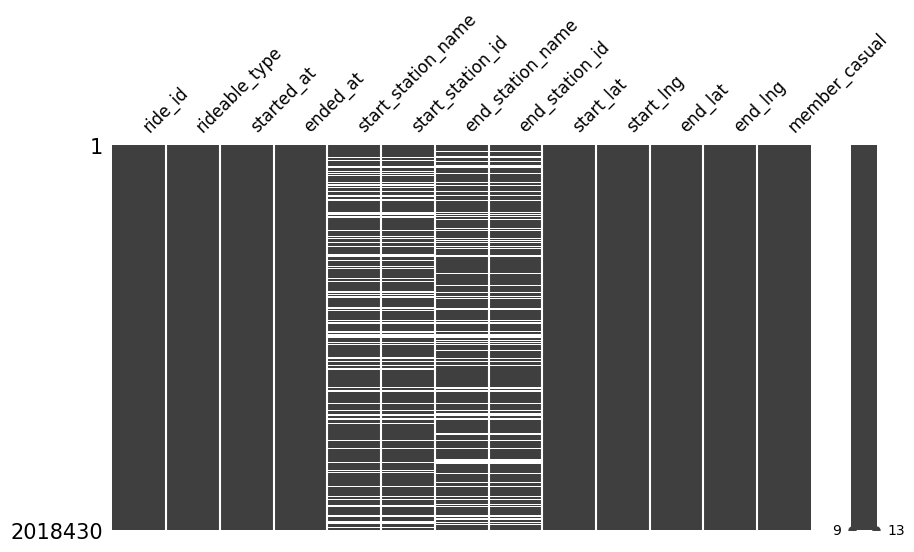

In [31]:
msno.matrix(daily_bikes_trips_df, figsize=(10,5), fontsize=12)

<Axes: >

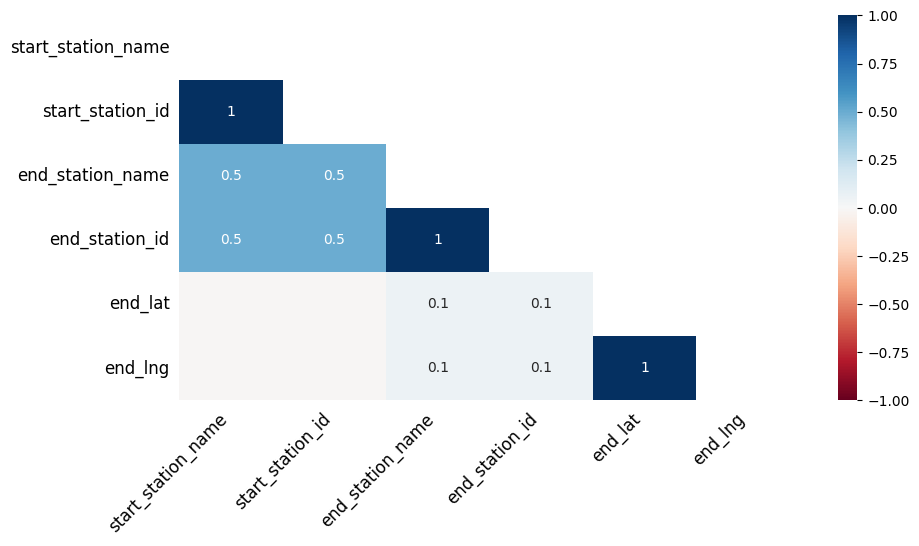

In [32]:
msno.heatmap(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

<Axes: >

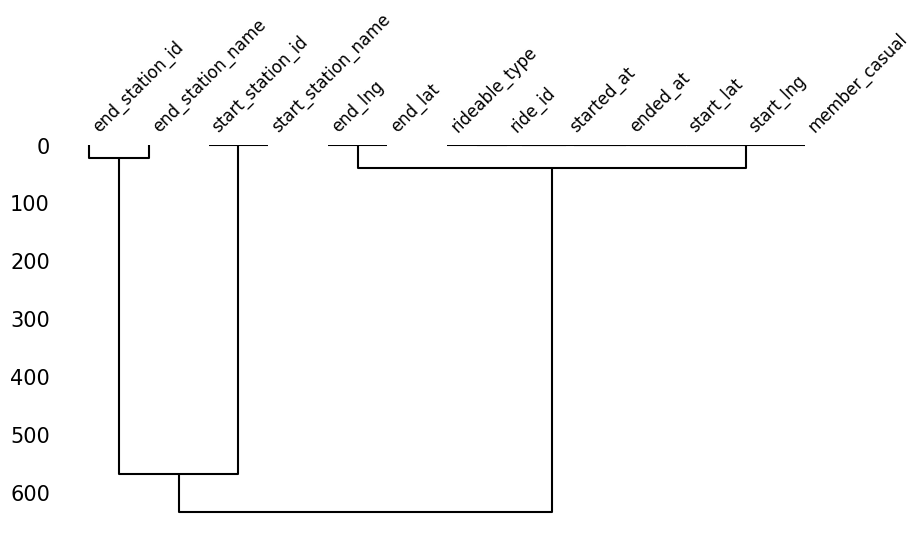

In [33]:
msno.dendrogram(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

######Out layer

In [143]:
# حساب عدد الرحلات لكل نوع دراجة
bike_type_counts = daily_bikes_trips_df['rideable_type'].value_counts().reset_index()
bike_type_counts.columns = ['rideable_type', 'count']

# حساب النسبة المئوية
total_rides = bike_type_counts['count'].sum()
bike_type_counts['percentage'] = (bike_type_counts['count'] / total_rides) * 100

# إنشاء المخطط الدائري
fig = px.pie(bike_type_counts,
             values='count',
             names='rideable_type',
             title='توزيع أنواع الدراجات حسب الرحلات',
             hover_data=['percentage'],
             labels={'rideable_type':'نوع الدراجة', 'count':'عدد الرحلات', 'percentage':'النسبة المئوية'})

# تحديث تنسيق النص ليشمل النسبة المئوية
fig.update_traces(textposition='inside', textinfo='percent+label')

# عرض المخطط
fig.write_image("bike_type_pie_chart.png")
fig.show(renderers="png")

In [35]:
# حساب مدة الرحلة بالثواني
daily_bikes_trips_df['duration'] = (daily_bikes_trips_df['ended_at'] - daily_bikes_trips_df['started_at']).dt.total_seconds()

<ipython-input-35-1991676314>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
# 1.  الرحلات القصيرة جداً (< 60 ثانية)
short_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] <= 60]
short_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
66,6137459834E41601,classic_bike,2024-05-04 10:44:06.000,2024-05-04 10:44:51.000,Maine Ave & Water St SW,31674,Maine Ave & Water St SW,31674,38.876747,-77.020945,38.876747,-77.020945,casual,45.000
166,9B27B6AAF9745304,classic_bike,2024-05-04 15:41:07.000,2024-05-04 15:42:03.000,1st & D St SE,31643,1st & D St SE,31643,38.884916,-77.005965,38.884916,-77.005965,casual,56.000
191,6353C1C863DB5750,classic_bike,2024-05-04 09:53:02.000,2024-05-04 09:53:07.000,15th St & Pennsylvania Ave NW,31129,15th St & Pennsylvania Ave NW,31129,38.896465,-77.033381,38.896465,-77.033381,casual,5.000
244,3EEF01728EDCFA27,classic_bike,2024-05-04 09:09:00.000,2024-05-04 09:09:04.000,Arizona Ave & MacArthur Blvd NW,31331,Arizona Ave & MacArthur Blvd NW,31331,38.927294,-77.103662,38.927294,-77.103662,casual,4.000
302,8306D54BA90B92E0,classic_bike,2024-05-04 08:23:52.000,2024-05-04 08:24:10.000,18th & R St NW,31278,18th & R St NW,31278,38.912648,-77.041834,38.912648,-77.041834,casual,18.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018138,7E69323F7EE824EB,electric_bike,2024-09-27 20:40:42.865,2024-09-27 20:41:41.460,16th & R St NW,31282,16th & R St NW,31282,38.912652,-77.036278,38.912652,-77.036278,member,58.595
2018268,D7AED6C13239B51E,electric_bike,2024-11-27 21:12:52.933,2024-11-27 21:13:36.848,None,None,None,None,38.810000,-77.110000,38.810000,-77.110000,member,43.915
2018286,6E6920806D651476,electric_bike,2024-11-27 12:07:36.286,2024-11-27 12:08:00.746,None,None,None,None,38.930000,-77.040000,38.930000,-77.040000,member,24.460
2018291,CC0C321F09ABC872,electric_bike,2024-11-27 13:08:00.373,2024-11-27 13:08:50.887,Lamont & Mt Pleasant NW,31107,Lamont & Mt Pleasant NW,31107,38.931900,-77.038800,38.931900,-77.038800,member,50.514


In [37]:
# 2.  الرحلات الطويلة جداً (> 24 ساعة)
long_bikes_trips_df = daily_bikes_trips_df[
    (daily_bikes_trips_df['duration'] >= 86400) &
    (daily_bikes_trips_df['end_lat'].notna()) &
    (daily_bikes_trips_df['end_lng'].notna())
]
long_bikes_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
5915,A9A7B0B468FBBE1B,classic_bike,2024-05-31 07:56:41.427,2024-06-01 08:15:58.067,8th & Eye St SE / Barracks Row,31608,1st & I St SE,31628,38.879200,-76.995300,38.878854,-77.005727,member,87556.640
12041,B042325A28DF9185,classic_bike,2024-09-15 11:06:01.682,2024-09-16 12:05:57.799,Mount Vernon Ave & Four Mile Run Park,31909,None,None,38.843422,-77.064016,38.820000,-77.050000,casual,89996.117
14486,DD00510A338D8731,classic_bike,2024-09-15 08:48:52.038,2024-09-16 09:48:46.366,Wilson Blvd & N Uhle St,31017,None,None,38.891696,-77.084600,38.880000,-77.050000,casual,89994.328
16595,E48F893C52385E5C,classic_bike,2024-12-07 23:34:12.089,2024-12-09 00:34:06.338,Ballston Metro / Stuart St & 9th St N,31037,None,None,38.881044,-77.111768,38.880000,-77.130000,casual,89994.249
61853,3C32AA51AF100F77,classic_bike,2024-11-01 15:57:52.445,2024-11-02 16:31:49.775,Potomac Ave & Half St SW,31648,King Greenleaf Rec Center,31654,38.869683,-77.010815,38.876211,-77.012443,casual,88437.330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820318,355B7E7A92AF7530,classic_bike,2024-06-01 13:10:20.464,2024-06-02 13:47:26.197,Maryland Ave & E St NE,31640,19th & East Capitol St SE,31601,38.896226,-76.992786,38.889600,-76.976900,member,88625.733
1889414,C4D670FB312F77D9,classic_bike,2024-04-01 13:10:06.000,2024-04-02 13:50:33.000,N Shore Dr & Wainwright Dr,32259,2nd St & Massachusetts Ave NE,31641,38.963782,-77.349764,38.894972,-77.003135,casual,88827.000
1971302,295A2A5B8542FA98,classic_bike,2024-03-13 20:57:47.000,2024-03-14 21:33:45.000,19th St & Constitution Ave NW,31235,16th & K St NW/BLM Plaza,31335,38.892212,-77.043074,38.902677,-77.035866,casual,88558.000
1975857,699C7BA259074B39,classic_bike,2024-05-09 21:44:28.000,2024-05-10 21:48:52.000,Anacostia Metro,31801,14th & V St NW,31101,38.862601,-76.994578,38.917764,-77.032096,casual,86664.000


In [38]:
# 3.  الرحلات التي بدأت بعد انتهائها
start_after_end_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] > daily_bikes_trips_df['ended_at']]
start_after_end_trips_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
16834,498821FB5B55B959,electric_bike,2024-04-09 22:25:46.000,2024-04-09 22:25:45.000,12th & U St NW,31268,None,None,38.916746,-77.028212,38.92,-77.03,casual,-1.000
30082,11E01284661EAC36,electric_bike,2024-04-28 08:15:52.000,2024-04-28 08:15:49.000,None,None,None,None,38.930000,-77.010000,38.93,-77.01,member,-3.000
30255,198CF9412019DCA0,electric_bike,2024-04-28 17:07:34.000,2024-04-28 17:07:33.000,None,None,None,None,38.920000,-77.030000,38.92,-77.03,member,-1.000
47069,1B558B48B9C8766A,electric_bike,2024-11-03 01:55:09.461,2024-11-03 01:09:12.902,20th & O St NW / Dupont South,31234,None,None,38.909048,-77.044669,38.93,-77.02,member,-2756.559
47134,8A094CD9870A944B,electric_bike,2024-11-03 01:54:28.282,2024-11-03 01:17:48.668,20th & L St NW,31250,None,None,38.903584,-77.044789,38.95,-76.96,member,-2199.614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885416,A6DC31AB8B6B5D79,electric_bike,2024-04-13 12:40:49.000,2024-04-13 12:40:47.000,17th & P St NW,31330,None,None,38.909839,-77.038324,38.91,-77.04,member,-2.000
1926335,5C7B652F5191001A,electric_bike,2024-04-24 12:30:24.000,2024-04-24 12:30:21.000,New Jersey Ave & K St NW,31642,None,None,38.902696,-77.013619,38.90,-77.01,casual,-3.000
1963019,AB325CDAB7CB6FA6,electric_bike,2024-05-10 12:21:33.000,2024-05-10 12:21:30.000,M St & Delaware Ave NE,31627,None,None,38.905545,-77.003016,38.91,-77.00,member,-3.000
2000712,98967D9E0363BA31,electric_bike,2024-01-30 19:53:57.000,2024-01-30 19:53:55.000,None,None,None,None,38.930000,-77.040000,38.93,-77.04,casual,-2.000


In [39]:

invalid_coords = daily_bikes_trips_df[
    daily_bikes_trips_df['start_lat'].isna() |
    daily_bikes_trips_df['start_lng'].isna() |
    ((daily_bikes_trips_df['start_lat'] == 0) & (daily_bikes_trips_df['start_lng'] == 0))
]
invalid_coords

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
7721,51D2A30A94774687,classic_bike,2024-07-23 18:43:44.342,2024-07-23 19:01:41.055,18th & M St NW,31221,3rd & H St NW,31604,0.0,0.0,0.0,0.0,member,1076.713
72046,86601221BD35C1C7,electric_bike,2024-10-23 08:37:06.431,2024-10-23 08:53:44.117,None,None,13th & U St NW,31132,0.0,0.0,0.0,0.0,member,997.686
152650,D248627806D986BD,electric_bike,2024-11-23 20:34:35.068,2024-11-23 20:38:05.539,18th & New Hampshire Ave NW,31324,14th & V St NW,31101,0.0,0.0,0.0,0.0,member,210.471
342331,D71342009F88CC6C,electric_bike,2024-01-30 11:29:35.000,2024-01-30 11:35:08.000,Georgia & New Hampshire Ave NW,31400,None,None,0.0,0.0,0.0,0.0,member,333.000
841381,E067FDF8DC37923D,electric_bike,2024-03-09 06:53:19.000,2024-03-09 07:03:22.000,17th & K St NW,31213,7th & F St NW / National Portrait Gallery,31232,0.0,0.0,0.0,0.0,member,603.000
1248309,696F1CC563B7A6CF,electric_bike,2024-03-29 12:45:48.000,2024-03-29 12:46:08.000,Columbia Pike & S Highland St,31096,None,None,0.0,0.0,0.0,0.0,member,20.000
1319143,D031E5D15DC71D4E,classic_bike,2024-10-30 17:25:38.028,2024-10-30 17:34:25.845,23rd St S & Hayes St,31938,28th St & S Meade St,31055,0.0,0.0,0.0,0.0,casual,527.817
1838437,A68BF558BCAFCAE0,electric_bike,2024-08-10 00:17:08.867,2024-08-10 00:25:13.510,None,None,None,None,0.0,0.0,0.0,0.0,member,484.643
1971921,BC6D07306F9AB01F,classic_bike,2024-03-13 21:10:52.000,2024-03-13 21:44:23.000,Pentagon City Metro / 12th St & S Hayes St,31005,Eads St & 12th St S,31071,0.0,0.0,0.0,0.0,casual,2011.000
2010695,40B36BC2EF29EF12,electric_bike,2024-07-21 18:20:40.388,2024-07-21 18:24:52.509,Stadium Armory Metro,31665,None,None,0.0,0.0,0.0,0.0,member,252.121


In [40]:

invalid_e_coords = daily_bikes_trips_df[
    daily_bikes_trips_df['end_lat'].isna() |
    daily_bikes_trips_df['end_lng'].isna() |
    ((daily_bikes_trips_df['end_lat'] == 0) & (daily_bikes_trips_df['end_lng'] == 0))
]
invalid_coords

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
7721,51D2A30A94774687,classic_bike,2024-07-23 18:43:44.342,2024-07-23 19:01:41.055,18th & M St NW,31221,3rd & H St NW,31604,0.0,0.0,0.0,0.0,member,1076.713
72046,86601221BD35C1C7,electric_bike,2024-10-23 08:37:06.431,2024-10-23 08:53:44.117,None,None,13th & U St NW,31132,0.0,0.0,0.0,0.0,member,997.686
152650,D248627806D986BD,electric_bike,2024-11-23 20:34:35.068,2024-11-23 20:38:05.539,18th & New Hampshire Ave NW,31324,14th & V St NW,31101,0.0,0.0,0.0,0.0,member,210.471
342331,D71342009F88CC6C,electric_bike,2024-01-30 11:29:35.000,2024-01-30 11:35:08.000,Georgia & New Hampshire Ave NW,31400,None,None,0.0,0.0,0.0,0.0,member,333.000
841381,E067FDF8DC37923D,electric_bike,2024-03-09 06:53:19.000,2024-03-09 07:03:22.000,17th & K St NW,31213,7th & F St NW / National Portrait Gallery,31232,0.0,0.0,0.0,0.0,member,603.000
1248309,696F1CC563B7A6CF,electric_bike,2024-03-29 12:45:48.000,2024-03-29 12:46:08.000,Columbia Pike & S Highland St,31096,None,None,0.0,0.0,0.0,0.0,member,20.000
1319143,D031E5D15DC71D4E,classic_bike,2024-10-30 17:25:38.028,2024-10-30 17:34:25.845,23rd St S & Hayes St,31938,28th St & S Meade St,31055,0.0,0.0,0.0,0.0,casual,527.817
1838437,A68BF558BCAFCAE0,electric_bike,2024-08-10 00:17:08.867,2024-08-10 00:25:13.510,None,None,None,None,0.0,0.0,0.0,0.0,member,484.643
1971921,BC6D07306F9AB01F,classic_bike,2024-03-13 21:10:52.000,2024-03-13 21:44:23.000,Pentagon City Metro / 12th St & S Hayes St,31005,Eads St & 12th St S,31071,0.0,0.0,0.0,0.0,casual,2011.000
2010695,40B36BC2EF29EF12,electric_bike,2024-07-21 18:20:40.388,2024-07-21 18:24:52.509,Stadium Armory Metro,31665,None,None,0.0,0.0,0.0,0.0,member,252.121


###### Summary

- There are a 26 row duplicated
- Whenever end_lat and end_lng are missing, end_station_name and end_station_id are also missing for those same rows

##### 3.1.2 For Stations Table


###### Data Info

In [41]:
stations_table_df.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [42]:
stations_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [43]:
stations_table_df.describe(include='all')

,id,name
count,821.000000,821
unique,NaN,820
top,NaN,Randle Circle & Minnesota Ave SE
freq,NaN,2
mean,31650.894032,NaN
std,447.232558,NaN
min,30200.000000,NaN
25%,31263.000000,NaN
50%,31630.000000,NaN
75%,32022.000000,NaN


###### Unique Values

In [44]:
stations_table_df.nunique()

,0
id,804
name,820


In [45]:
rows_with_non_unique_name = stations_table_df[stations_table_df.duplicated(subset=['name'], keep=False)]
print("Rows with non-unique Names:")
rows_with_non_unique_name

Rows with non-unique Names:


,id,name
465,31702,Randle Circle & Minnesota Ave SE
492,31799,Randle Circle & Minnesota Ave SE


In [46]:
# drop duplicated name row
stations_table_df = stations_table_df.drop_duplicates(subset=['name'], keep='first')

In [47]:
rows_with_non_unique_id = stations_table_df[stations_table_df.duplicated(subset=['id'], keep=False)]
print("Rows with non-unique IDs:")
rows_with_non_unique_id

Rows with non-unique IDs:


,id,name
45,31045,S Payne St & King St
46,31045,Commerce St & Fayette St
133,31133,20th & Columbia Rd NW
134,31133,20th St & Columbia Rd NW
135,31133,19th St & Wyoming Ave NW
166,31225,C & O Canal & Wisconsin Ave NW
167,31225,Wisconsin Ave & K St NW
281,31339,18th St & Ingleside Terr NW
282,31339,18th St & Ingleside Ter NW
284,31380,Roland Clarke Pl & Sunrise Valley Dr


###### Duplicated Rows

In [48]:
print(stations_table_df.duplicated().sum())

0


###### Null Values

In [49]:
print(stations_table_df.isnull().sum())

id      0
name    0
dtype: int64


###### Summary

- There is one name duplicated "Randle Circle & Minnesota Ave SE", and 17 IDs duplicated.
- There are no missing values

##### 3.1.3 For Stations Info

###### Data Info

In [50]:
stations_info_df.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [51]:
stations_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [52]:
stations_info_df.describe(include='all')

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
count,7.940000e+02,7.940000e+02,794,794,794,0.0,794,794.00000,794.000000,794.000000,...,794,794.000000,794,744.000000,794,0.0,794.000000,794.000000,794,7.940000e+02
unique,NaN,NaN,794,1,794,NaN,125,NaN,NaN,NaN,...,1,NaN,1,NaN,1,NaN,NaN,NaN,2,NaN
top,NaN,NaN,Old Meadow Rd & Cathy Ln,classic,1890899920583743818,NaN,2025/05/05 20:26:08+00,NaN,NaN,NaN,...,NO,NaN,"KEY,CREDITCARD",NaN,DCA-CABI,NaN,NaN,NaN,2025/05/05 20:27:29+00,NaN
freq,NaN,NaN,1,794,1,NaN,14,NaN,NaN,NaN,...,794,NaN,794,NaN,794,NaN,NaN,NaN,604,NaN
mean,-8.579029e+06,4.708386e+06,NaN,NaN,NaN,NaN,NaN,10.13728,0.021411,6.419395,...,NaN,17.234257,NaN,53.034946,NaN,NaN,38.907156,-77.066727,NaN,2.612862e+08
std,1.073636e+04,8.392150e+03,NaN,NaN,NaN,NaN,NaN,6.07810,0.271923,5.968744,...,NaN,5.712581,NaN,27.714636,NaN,NaN,0.058643,0.096446,NaN,3.217789e+03
min,-8.614982e+06,4.688330e+06,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,...,NaN,8.000000,NaN,40.000000,NaN,NaN,38.766844,-77.389696,NaN,2.612840e+08
25%,-8.582008e+06,4.704036e+06,NaN,NaN,NaN,NaN,NaN,5.00000,0.000000,2.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.876769,-77.093483,NaN,2.612842e+08
50%,-8.576564e+06,4.707386e+06,NaN,NaN,NaN,NaN,NaN,10.00000,0.000000,5.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.900192,-77.044581,NaN,2.612844e+08
75%,-8.572478e+06,4.711950e+06,NaN,NaN,NaN,NaN,NaN,14.00000,0.000000,10.000000,...,NaN,19.000000,NaN,43.000000,NaN,NaN,38.932094,-77.007883,NaN,2.612846e+08


In [53]:
stations_info_df = stations_info_df[[
    'STATION_ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CAPACITY'
]]

###### Unique Values

In [54]:
stations_info_df.nunique()

,0
STATION_ID,794
NAME,794
LATITUDE,789
LONGITUDE,792
CAPACITY,29


###### Duplicated Rows

In [55]:
print(stations_info_df.duplicated().sum())

0


In [56]:
dublicate_name=stations_info_df[stations_info_df.duplicated(subset=["NAME"])]
dublicate_name

,STATION_ID,NAME,LATITUDE,LONGITUDE,CAPACITY


###### Null Values

In [57]:
print(stations_info_df.isnull().sum())

STATION_ID    0
NAME          0
LATITUDE      0
LONGITUDE     0
CAPACITY      0
dtype: int64


###### Merge with Stations Table Dataframe

In [58]:
stations_df = pd.merge(stations_info_df, stations_table_df, left_on='NAME', right_on='name', how='inner')
stations_df = stations_df.drop(columns=['name'])
stations_df["id"]=stations_df["id"].astype("Int64")
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION_ID  776 non-null    object 
 1   NAME        776 non-null    object 
 2   LATITUDE    776 non-null    float64
 3   LONGITUDE   776 non-null    float64
 4   CAPACITY    776 non-null    int64  
 5   id          776 non-null    Int64  
dtypes: Int64(1), float64(2), int64(1), object(2)
memory usage: 37.3+ KB


In [59]:
invalid = stations_df[
    stations_df['LATITUDE'].isna() |
    stations_df['LONGITUDE'].isna() |
    ((stations_df['LATITUDE'] == 0) & (stations_df['LONGITUDE'] == 0))
]
invalid

,STATION_ID,NAME,LATITUDE,LONGITUDE,CAPACITY,id


###### Summary

- There are no duplicated rows.
- There is no data in "STATION_STATUS" and "GIS_ID" columns.

##### 3.1.4 For Daily Weather Info

###### Data Info

In [60]:
daily_weather_info_df.head()

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [61]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [62]:
daily_weather_info_df.describe(include='all')

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
count,366,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366,366,366.000000,366,366,366
unique,1,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366,366,NaN,8,33,6
top,"Washington,DC,USA",2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-31T07:26:48,2024-12-31T16:56:19,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
freq,366,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,197,159,196
mean,NaN,NaN,20.795355,12.082514,16.251913,62.434973,23.338798,23.338798,12.787158,3.256831,63.997268,NaN,NaN,0.486667,NaN,NaN,NaN
std,NaN,NaN,9.442725,8.762690,8.885863,13.624988,7.714631,7.714631,4.696460,4.002540,25.299497,NaN,NaN,0.292243,NaN,NaN,NaN
min,NaN,NaN,-1.700000,-9.000000,-5.000000,32.600000,8.900000,8.900000,3.400000,0.000000,2.100000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,12.800000,4.900000,8.825000,52.625000,17.700000,17.700000,9.500000,0.000000,45.225000,NaN,NaN,0.250000,NaN,NaN,NaN
50%,NaN,NaN,22.100000,11.950000,17.550000,61.850000,21.950000,21.950000,12.250000,0.500000,68.300000,NaN,NaN,0.500000,NaN,NaN,NaN
75%,NaN,NaN,28.375000,19.900000,24.075000,71.975000,27.275000,27.275000,15.400000,6.700000,84.775000,NaN,NaN,0.750000,NaN,NaN,NaN


In [63]:
daily_weather_info_df=daily_weather_info_df[[
    "datetime","conditions"
]]


###### Unique Values

In [64]:
daily_weather_info_df.nunique()

,0
datetime,366
conditions,8


In [65]:
conditions_value=daily_weather_info_df["conditions"].unique()
conditions_value

array(['Rain, Overcast', 'Partially cloudy', 'Rain, Partially cloudy',
       'Snow, Rain, Overcast', 'Snow, Rain, Partially cloudy', 'Clear',
       'Snow, Partially cloudy', 'Overcast'], dtype=object)

###### Duplicated Rows

In [66]:
print(daily_weather_info_df.duplicated().sum())

0


###### Null Values

In [67]:
print(daily_weather_info_df.isnull().sum())

datetime      0
conditions    0
dtype: int64


###### Summary

- There are no duplicated rows
- There are no missing values

##### 3.1.5 For Metro Bus Stops

###### Data Info

In [68]:
metro_bus_stops_df.head()

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
0,-8.581259e+06,4.715817e+06,1311739,1003448,15663,PRS,2011/08/22 04:00:00+00,UNK,44TH ST NW,JENIFER ST NW,...,NaN,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54845,NaN,NON,NaN
1,-8.540493e+06,4.714288e+06,1310541,3003035,14833,PRS,2001/12/30 05:00:00+00,REV,HARBOUR WAY,MITCHELLVILLE RD,...,NaN,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54846,NaN,NON,NaN
2,-8.591135e+06,4.698290e+06,1302469,5000849,2134,PRS,1901/01/01 05:00:00+00,REV,SLEEPY HOLLOW MANOR,COLUMBIA PIKE,...,NaN,{22649B1B-617C-4511-9786-D465C7142788},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54847,NaN,NON,NaN
3,-8.577431e+06,4.682321e+06,1305286,5001858,11889,PRS,1974/11/25 05:00:00+00,REV,CUSHMAN PL,WAYNEWOOD BLVD,...,NaN,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54848,NaN,NON,NaN
4,-8.578561e+06,4.680594e+06,1305279,5001885,11919,PRS,1901/01/01 05:00:00+00,REV,PRICES LN,VERNON VIEW DR,...,NaN,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54849,NaN,NON,NaN


In [69]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

In [70]:
metro_bus_stops_df.describe(include='all')

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
count,1.004400e+04,1.004400e+04,1.004400e+04,1.004400e+04,10044.000000,10044,10044,10044,10044,10044,...,0.0,10044,10044,10044,10044,10044,10044.000000,547,10044,267
unique,NaN,NaN,NaN,NaN,NaN,1,1776,4,4575,1187,...,NaN,10044,1,1,1,1,NaN,1,1,52
top,NaN,NaN,NaN,NaN,NaN,PRS,1901/01/01 05:00:00+00,REV,BUS BAY C,NEW HAMPSHIRE AVE,...,NaN,{F60A4E53-3D0C-4C97-BEFD-6F591FDFC657},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,NaN,YES,NON,MSTN_070
freq,NaN,NaN,NaN,NaN,NaN,10044,2777,7583,38,127,...,NaN,1,10044,10044,10044,10044,NaN,547,10044,14
mean,-8.573589e+06,4.709026e+06,1.309595e+06,2.758170e+06,10584.951016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60009.754480,NaN,NaN,NaN
std,1.292582e+04,1.178967e+04,1.779232e+04,1.580693e+06,12251.967007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2900.900168,NaN,NaN,NaN
min,-8.621634e+06,4.677973e+06,1.300005e+06,1.000001e+06,66.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54845.000000,NaN,NaN,NaN
25%,-8.581023e+06,4.700649e+06,1.303241e+06,1.002959e+06,4445.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57499.750000,NaN,NaN,NaN
50%,-8.572242e+06,4.707842e+06,1.306389e+06,3.000786e+06,8772.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60010.500000,NaN,NaN,NaN
75%,-8.565564e+06,4.716428e+06,1.309382e+06,3.004256e+06,13877.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,62521.250000,NaN,NaN,NaN


###### Unique Values

In [71]:
metro_bus_stops_df.nunique()

,0
X,10044
Y,10044
EGIS_ID,10044
REG_ID,10044
BSTP_GEO_ID,9904
...,...
EDITED,1
OBJECTID,10044
SNOWPRIORITY,1
BSTP_OPS_FTU_TCD,1


###### Duplicated Rows

In [72]:
print(metro_bus_stops_df.duplicated().sum())

0


###### Null Values

In [73]:
print(metro_bus_stops_df.isnull().sum())

X                      0
Y                      0
EGIS_ID                0
REG_ID                 0
BSTP_GEO_ID            0
                    ... 
EDITED                 0
OBJECTID               0
SNOWPRIORITY        9497
BSTP_OPS_FTU_TCD       0
MSTN_ID             9777
Length: 79, dtype: int64


###### Summary

- There is no data in "SNOWPRIORITY" column

##### 3.1.6 For Shuttle Bus

###### Data Info

In [74]:
shuttle_bus_stops_df.head()

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
0,-8.581105e+06,4.715777e+06,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,...,143439.120000,38.958828,-77.085372,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,1
1,-8.571861e+06,4.714828e+06,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,...,142700.050000,38.952201,-77.002336,NaN,{86FD8D0D-8512-4B67-BC46-F4702DDECBF7},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,2
2,-8.580446e+06,4.714237e+06,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,...,142244.710000,38.948072,-77.079460,NaN,{39D07F3C-F0BC-4A81-A48E-B84F4476C0FB},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,3
3,-8.580342e+06,4.714213e+06,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,...,142225.640001,38.947901,-77.078521,NaN,{F5F56BB9-4FA5-4990-A245-49BD5CE9FF56},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,4
4,-8.580407e+06,4.713930e+06,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,...,142006.200001,38.945924,-77.079102,NaN,{81C0AAA8-0A4A-46DB-B21F-290E8C261FB4},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,5


In [75]:
shuttle_bus_stops_df.describe(include='all')

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
count,1.020000e+02,1.020000e+02,102,102,76,84,95,93,23,77,...,102.000000,102.000000,102.000000,0.0,102,0.0,0.0,102,102,102.000000
unique,NaN,NaN,25,98,71,80,3,3,22,21,...,NaN,NaN,NaN,NaN,102,NaN,NaN,1,3,NaN
top,NaN,NaN,Reston Limousine,NEBRASKA AVENUE NW FROM WARD CIRCLE NW TO 42ND...,NOMA (Gallaudet) Metro Station,Nebraska Ave NW & Mass Ave NW,No,No,No Metro Stop,No,...,NaN,NaN,NaN,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,NaN
freq,NaN,NaN,30,2,2,5,80,71,2,52,...,NaN,NaN,NaN,NaN,1,NaN,NaN,102,41,NaN
mean,-8.576019e+06,4.708610e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137877.543576,38.908756,-77.039703,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
std,2.862833e+03,2.700879e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2096.260170,0.018891,0.025716,NaN,NaN,NaN,NaN,NaN,NaN,29.588849
min,-8.582103e+06,4.704030e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,134321.460000,38.876724,-77.094343,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,-8.577548e+06,4.706898e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136547.905000,38.896778,-77.053423,NaN,NaN,NaN,NaN,NaN,NaN,26.250000
50%,-8.576228e+06,4.707775e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137229.315000,38.902911,-77.041565,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
75%,-8.574059e+06,4.709780e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138786.215000,38.916927,-77.022083,NaN,NaN,NaN,NaN,NaN,NaN,76.750000


In [76]:
shuttle_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X                      102 non-null    float64
 1   Y                      102 non-null    float64
 2   COMPANY                102 non-null    object 
 3   ADDRESS                102 non-null    object 
 4   ATTRACTION             76 non-null     object 
 5   CROSSROADS             84 non-null     object 
 6   METERS                 95 non-null     object 
 7   METRO_BUS_ZONE         93 non-null     object 
 8   METRO_STOP_ID          23 non-null     object 
 9   OTHER                  77 non-null     object 
 10  NPS                    0 non-null      float64
 11  NUM_SHARED_OPER        102 non-null    int64  
 12  RUSH_HOUR_RESTR        95 non-null     object 
 13  LZ_HOTEL_OR_COMM       95 non-null     object 
 14  SPACE_LOC_ON_BLOCK     93 non-null     object 
 15  NO_STO

- There is no data in "NPS", "SE_ANNO_CAD_DATA", "CREATOR", and "CREATED" columns

###### Unique Values

In [77]:
shuttle_bus_stops_df.nunique()

,0
X,96
Y,96
COMPANY,25
ADDRESS,98
ATTRACTION,71
CROSSROADS,80
METERS,3
METRO_BUS_ZONE,3
METRO_STOP_ID,22
OTHER,21


###### Duplicated Rows

In [78]:
print(shuttle_bus_stops_df.duplicated().sum())

0


###### Null Values

In [79]:
print(shuttle_bus_stops_df.isnull().sum())

X                          0
Y                          0
COMPANY                    0
ADDRESS                    0
ATTRACTION                26
CROSSROADS                18
METERS                     7
METRO_BUS_ZONE             9
METRO_STOP_ID             79
OTHER                     25
NPS                      102
NUM_SHARED_OPER            0
RUSH_HOUR_RESTR            7
LZ_HOTEL_OR_COMM           7
SPACE_LOC_ON_BLOCK         9
NO_STOP_NO_STAND_AREA      8
MAR_ID                     0
GIS_ID                     0
XCOORD                     0
YCOORD                     0
LATITUDE                   0
LONGITUDE                  0
SE_ANNO_CAD_DATA         102
GLOBALID                   0
CREATOR                  102
CREATED                  102
EDITOR                     0
EDITED                     0
OBJECTID                   0
dtype: int64


###### Summary

##### 3.1.7 For Residential and Visitor Parking Zones

###### Data Info

In [80]:
residential_and_visitor_parking_zones_df.head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,None,None,None,None,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.99,..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,None,None,None,None,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,None,None,None,None,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,None,None,None,None,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,None,None,None,None,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [81]:
residential_and_visitor_parking_zones_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int32   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int32   
 11  SHAPEAREA   40 non-null     int32   
 12  SHAPELEN    40 non-null     int32   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int32(4), object(8)
memory usage: 3.9+ KB


In [82]:
residential_and_visitor_parking_zones_df.describe(include='all')

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
count,40,40.000000,40,40,40,40.000000,0,0,0,0,40.000000,40.0,40.0,40
unique,40,NaN,40,40,40,NaN,0,0,0,0,NaN,NaN,NaN,40
top,ANC 4A,NaN,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-77.0333090318554 38.989994707638985...
freq,1,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,4.500000,NaN,NaN,NaN,10665.805206,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
std,NaN,2.298271,NaN,NaN,NaN,4079.014381,NaN,NaN,NaN,NaN,11.690452,0.0,0.0,NaN
min,NaN,1.000000,NaN,NaN,NaN,3789.580558,NaN,NaN,NaN,NaN,1.000000,0.0,0.0,NaN
25%,NaN,2.750000,NaN,NaN,NaN,7498.497840,NaN,NaN,NaN,NaN,10.750000,0.0,0.0,NaN
50%,NaN,4.500000,NaN,NaN,NaN,10601.180044,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
75%,NaN,6.250000,NaN,NaN,NaN,12764.489078,NaN,NaN,NaN,NaN,30.250000,0.0,0.0,NaN


###### Unique Values

In [83]:
residential_and_visitor_parking_zones_df.nunique()

,0
NAME,40
RPP_ZONE,8
ANC_ID,40
WEB_URL,40
GIS_ID,40
SHAPE_LENG,40
CREATOR,0
CREATED,0
EDITOR,0
EDITED,0


###### Duplicated Rows

In [84]:
print(residential_and_visitor_parking_zones_df.duplicated().sum())

0


###### Null Values

In [85]:
print(residential_and_visitor_parking_zones_df.isnull().sum())

NAME           0
RPP_ZONE       0
ANC_ID         0
WEB_URL        0
GIS_ID         0
SHAPE_LENG     0
CREATOR       40
CREATED       40
EDITOR        40
EDITED        40
OBJECTID       0
SHAPEAREA      0
SHAPELEN       0
geometry       0
dtype: int64


In [86]:
residential_and_visitor_parking_zones_df = residential_and_visitor_parking_zones_df[residential_and_visitor_parking_zones_df.geometry.notnull()]
residential_and_visitor_parking_zones_df = residential_and_visitor_parking_zones_df[residential_and_visitor_parking_zones_df.is_valid]


###### Summary

- There is no data in "CREATOR", "CREATED", "EDITOR",and "EDITED" columns

#####3.1.8 For Central Business District

In [87]:
cbd_polygon_df.head()

,OBJECTID,ID,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,0,DDOT_CBD_1,{88E0BE6C-77A4-4C9B-96DA-39C3D223AA41},None,None,None,None,0,0,"POLYGON ((-77.05028 38.91194, -77.05029 38.911..."


### 3.2. Handling Missing Values
* Decide on strategies for missing values (imputation, removal) for each relevant column in each dataset. Document justifications.

##### 3.2.1 For Daily Bikes Trips



###### Drop all the missing values in 'end_lat' and 'end_lng'

In [88]:
# delete all the missing values in 'end_lat' and 'end_lng'
daily_bikes_trips_df = daily_bikes_trips_df.dropna(subset=['end_lat', 'end_lng'])
print(f"Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: {daily_bikes_trips_df.shape}")

Shape of daily_bikes_trips_df after dropping rows with missing end_lat/end_lng: (2016879, 14)


In [89]:
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['started_at'] < daily_bikes_trips_df['ended_at']]
daily_bikes_trips_df = daily_bikes_trips_df[daily_bikes_trips_df['duration'] > 60]

In [90]:
# 1. إنشاء سلسلتين (Series) لربط اسم المحطة بإحداثياتها
lat_map = stations_df.set_index('NAME')['LATITUDE']
lng_map = stations_df.set_index('NAME')['LONGITUDE']

# 2. تعويض start_lat وstart_lng إذا كانت (0, 0)
start_lat_null = (daily_bikes_trips_df['start_lat'] == 0) & \
                 (daily_bikes_trips_df['start_lng'] == 0) & \
                 daily_bikes_trips_df['start_station_name'].notna()

daily_bikes_trips_df.loc[start_lat_null, 'start_lat'] = \
    daily_bikes_trips_df.loc[start_lat_null, 'start_station_name'].map(lat_map)

daily_bikes_trips_df.loc[start_lat_null, 'start_lng'] = \
    daily_bikes_trips_df.loc[start_lat_null, 'start_station_name'].map(lng_map)

# 3. تعويض end_lat وend_lng إذا كانت (0, 0)
end_lat_null = (daily_bikes_trips_df['end_lat'] == 0) & \
               (daily_bikes_trips_df['end_lng'] == 0) & \
               daily_bikes_trips_df['end_station_name'].notna()

daily_bikes_trips_df.loc[end_lat_null, 'end_lat'] = \
    daily_bikes_trips_df.loc[end_lat_null, 'end_station_name'].map(lat_map)

daily_bikes_trips_df.loc[end_lat_null, 'end_lng'] = \
    daily_bikes_trips_df.loc[end_lat_null, 'end_station_name'].map(lng_map)

In [91]:
num_of_zero_s = daily_bikes_trips_df['start_lat'].value_counts().get(0, 0)
num_of_zero_e = daily_bikes_trips_df['end_lat'].value_counts().get(0, 0)
print("number of row wize zero value in start lat",num_of_zero_s)
print("number of row wize zero value in end lat",num_of_zero_e)

number of row wize zero value in start lat 2
number of row wize zero value in end lat 3


In [92]:
mask = (daily_bikes_trips_df['start_lat'] == 0.0) | (daily_bikes_trips_df['end_lat'] == 0.0)

daily_bikes_trips_df = daily_bikes_trips_df[~mask].reset_index(drop=True)

In [93]:
daily_bikes_trips_df.shape

(1978494, 14)

In [94]:
def is_low_precision(coord):
    try:
        s = f"{float(coord):.10f}"
        decimal_part = s.split('.')[-1]
        significant_digits = len(decimal_part.rstrip('0'))
        return significant_digits <= 3
    except:
        return True

def haversine_distance(latlng1, latlng2):
    R = 6371.0
    lat1, lng1 = np.radians(latlng1)
    lat2, lng2 = np.radians(latlng2)

    dlat = lat2 - lat1
    dlng = lng2 - lng1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


def correct_low_precision_coords(df, lat_col, lng_col, stations_df=None, use_haversine=False):

    df = df.copy()
    df[f'{lat_col}_before'] = df[lat_col]
    df[f'{lng_col}_before'] = df[lng_col]

    low_precision_mask = df[lat_col].apply(is_low_precision) | df[lng_col].apply(is_low_precision)
    low_precision_rows = df[low_precision_mask]
    high_precision_rows = df[~low_precision_mask]

    # اختيار المرجعيات
    if stations_df is not None:
        ref_coords = stations_df[['LATITUDE', 'LONGITUDE']].drop_duplicates().values
    else:
        ref_coords = high_precision_rows[[lat_col, lng_col]].drop_duplicates().values

    if len(ref_coords) == 0:
        print("لا توجد مرجعيات دقيقة لتصحيح الإحداثيات.")
        return df

    # استخدام المسافة الإقليدية أو Haversine
    if use_haversine:
        from sklearn.neighbors import BallTree

        # استخدام BallTree مع Haversine
        tree = BallTree(np.radians(ref_coords), metric="haversine")
        distances, indices = tree.query(np.radians(low_precision_rows[[lat_col, lng_col]].values), k=1)
        corrected_coords = ref_coords[indices.flatten()]
    else:
        # استخدام NearestNeighbors عادي
        model = NearestNeighbors(n_neighbors=1)
        model.fit(ref_coords)
        distances, indices = model.kneighbors(low_precision_rows[[lat_col, lng_col]].values)
        corrected_coords = ref_coords[indices.flatten()]

    # تحديث الإحداثيات المنخفضة الدقة
    corrected_low_precision = low_precision_rows.copy()
    corrected_low_precision[[lat_col, lng_col]] = corrected_coords

    # دمج البيانات
    df_fixed = pd.concat([high_precision_rows, corrected_low_precision], ignore_index=True)

    # إعادة ترتيب العمود ليكون كما كان
    df_fixed = df_fixed[df.columns]

    return df_fixed


In [95]:

df_fixed_starts = correct_low_precision_coords(daily_bikes_trips_df, 'start_lat', 'start_lng',stations_df,True)
df_fully_fixed = correct_low_precision_coords(df_fixed_starts, 'end_lat', 'end_lng',stations_df,True)


In [96]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['start_lat_before'] - df_fully_fixed['start_lat']) > 0.03) |
    (abs(df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']) > 0.03)
]

print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 48


In [97]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['end_lat_before'] - df_fully_fixed['end_lat']) > 0.03) |
    (abs(df_fully_fixed['end_lng_before'] - df_fully_fixed['end_lng']) > 0.03)
]

print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 161


In [98]:
changes = df_fully_fixed[
    (abs(df_fully_fixed['start_lat_before'] - df_fully_fixed['start_lat']) > 0.03) |
    (abs(df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']) > 0.03) |
    (abs(df_fully_fixed['end_lat_before'] - df_fully_fixed['end_lat']) > 0.03) |
    (abs(df_fully_fixed['end_lng_before'] - df_fully_fixed['end_lng']) > 0.03)
]
print("عدد الصفوف التي تحتوي على فروقات كبيرة:", len(changes))

عدد الصفوف التي تحتوي على فروقات كبيرة: 187


In [99]:
daily_bikes_trips_df_reset = daily_bikes_trips_df.reset_index(drop=True)
df_fully_fixed_reset = df_fully_fixed.reset_index(drop=True)

distance = df_fully_fixed['start_lng_before'] - df_fully_fixed['start_lng']

comparison_df = pd.DataFrame({
    'start_lat_before':  df_fully_fixed['start_lng_before'],
    'start_lat_after': df_fully_fixed['start_lng'],
    'difference': distance
})

if 'start_station_name' in daily_bikes_trips_df_reset.columns:
    comparison_df['start_station_name'] = daily_bikes_trips_df_reset['start_station_name']

zero_difference_rows = comparison_df[comparison_df['difference'] != 0]

zero_difference_rows.sort_values(by='difference', ascending=False).head(20)


,start_lat_before,start_lat_after,difference,start_station_name
1904618,-77.10,-77.150359,0.050359,None
1464539,-76.96,-77.001030,0.041030,Thomas Circle
1914127,-76.90,-76.935578,0.035578,None
1895411,-76.94,-76.975300,0.035300,North Capitol & R St NE
1864416,-76.94,-76.975300,0.035300,None
1900698,-76.94,-76.975300,0.035300,None
1775327,-76.97,-77.000770,0.030770,1st & M St NE
1775328,-76.97,-77.000770,0.030770,South Dakota Ave & Bladensburg Rd NE
1870791,-76.97,-77.000770,0.030770,Columbia Pike & Monroe St
1774904,-76.97,-77.000770,0.030770,18th & R St NW


In [100]:
def fill_missing_station_info(trips_df, stations_df, point_prefix):

    # إعداد أسماء الأعمدة
    lat_col = f'{point_prefix}_lat'
    lng_col = f'{point_prefix}_lng'

    name_col = f'{point_prefix}_station_name'
    id_col = f'{point_prefix}_station_id'

    # تجهيز جدول المحطات المرجعي
    ref = stations_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'NAME', 'id']) \
                     .drop_duplicates(subset=['LATITUDE', 'LONGITUDE'])

    # دمج على الإحداثيات
    merged = trips_df.merge(
        ref[['LATITUDE', 'LONGITUDE', 'NAME', 'id']],
        left_on=[lat_col, lng_col],
        right_on=['LATITUDE', 'LONGITUDE'],
        how='left',
    )


    merged[name_col] = merged[name_col].fillna(merged['NAME'])
    merged[id_col] = merged[id_col].fillna(merged['id'])


    merged.drop(columns=['LATITUDE', 'LONGITUDE', 'NAME', 'id'], inplace=True)

    return merged


In [101]:
df_filled = fill_missing_station_info(df_fully_fixed, stations_df, point_prefix='start')

In [102]:
df_filled = fill_missing_station_info(df_filled, stations_df, point_prefix='end')

In [103]:
print(df_filled.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
duration              0
start_lat_before      0
start_lng_before      0
end_lat_before        0
end_lng_before        0
dtype: int64


In [104]:
df_filled=df_filled.drop(columns=["start_lat_before" ,	"start_lng_before" ,	"end_lat_before"	, "end_lng_before"],axis=1)

In [105]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978494 entries, 0 to 1978493
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
dtypes: datetime64[ns](2), float64(5), object(7)
memory usage: 211.3+ MB


##### 3.2.2 For Stations

In [106]:
stations_df.dropna(subset=['id'], inplace=True)

In [107]:
print(stations_df.isnull().sum())

STATION_ID    0
NAME          0
LATITUDE      0
LONGITUDE     0
CAPACITY      0
id            0
dtype: int64


##### 3.2.3 For Metro Bus Stops

In [108]:
metro_bus_stops_df.dropna(axis=1, how='all', inplace=True)

In [109]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

##### 3.2.4 For Shuttle Bus Stops

In [110]:
shuttle_bus_stops_df.dropna(axis=1, how='all', inplace=True)

##### 3.2.5 For Residential and Visitor Parking Zones

In [111]:
residential_and_visitor_parking_zones_df.dropna(axis=1, how='all', inplace=True)

### 3.3. Data Type Conversion
* Ensure dates are in datetime format.
* Convert other columns to appropriate types (e.g., numeric, categorical).

##### 3.3.1 For Daily Bikes Trips

In [112]:
daily_bikes_trips_df=df_filled.copy()

In [113]:
daily_bikes_trips_df['start_station_id'] = daily_bikes_trips_df['start_station_id'].astype("Float64").astype('Int64')
daily_bikes_trips_df['end_station_id'] = daily_bikes_trips_df['end_station_id'].astype("Float64").astype('Int64')
daily_bikes_trips_df['date'] = pd.to_datetime(daily_bikes_trips_df['started_at']).dt.date

In [114]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978494 entries, 0 to 1978493
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    Int64         
 6   end_station_name    object        
 7   end_station_id      Int64         
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  duration            float64       
 14  date                object        
dtypes: Int64(2), datetime64[ns](2), float64(5), object(6)
memory usage: 230.2+ MB


##### 3.3.3 For Daily Weather Info

In [115]:
daily_weather_info_df['datetime'] = pd.to_datetime(daily_weather_info_df['datetime']).dt.date

<ipython-input-115-325138308>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    366 non-null    object
 1   conditions  366 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


### 3.4. Merging Datasets
* Merge `Daily Bikes Trips` with `Stations Table` (for start and end stations).
* Merge with `Daily Weather Info`.
* Perform spatial join with `Residential and Visitor Parking Zones` (ensure CRS transformation: EPSG:4326 to a projected CRS like EPSG:6933 for distance calculations, then back if needed or operate in projected CRS).
* Document the merge keys and types of joins used.

In [117]:
# merged_df = daily_bikes_trips_df.copy()
# Merge Daily Bikes Trips with Stations Table for start station information
# Merge Key: 'start_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    daily_bikes_trips_df,
    stations_df.add_prefix("start_"),
    left_on='start_station_id',
    right_on='start_id',
    how='left'
)
# Drop the redundant 'id' column from the merge
merged_df.drop(columns=["start_NAME",'start_STATION_ID','start_id', 'start_LONGITUDE', 'start_LATITUDE'], errors='ignore', inplace=True)

In [118]:
# Merge Daily Bikes Trips with Stations Table for end station information
# Merge Key: 'end_station_id' in daily_bikes_trips_df and 'id' in stations_table_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    stations_df.add_prefix("end_"),
    left_on='end_station_id',
    right_on='end_id',
    how='left'
)

# Drop the redundant 'id' column from the merge
merged_df.drop(columns=["end_NAME",'end_STATION_ID','end_id', 'end_LONGITUDE', 'end_LATITUDE'], errors='ignore', inplace=True)


In [119]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
start_CAPACITY        13396
end_CAPACITY          14079
dtype: int64


In [120]:
# Merge Daily Bikes Trips with Daily Weather Info
# Merge Key: 'date' in daily_bikes_trips_df and 'datetime' in daily_weather_info_df
# Join Type: Left Join (keep all rows from daily_bikes_trips_df)
merged_df = pd.merge(
    merged_df,
    daily_weather_info_df,
    left_on='date',
    right_on='datetime',
    how='left'
)

# Drop the redundant datetime column
merged_df.drop(columns=['datetime'], errors='ignore', inplace=True)


In [121]:
print(merged_df.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
duration                  0
date                      0
start_CAPACITY        13396
end_CAPACITY          14079
conditions                4
dtype: int64


In [122]:
gdf_start = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['start_lng'], merged_df['start_lat']),
    crs="EPSG:4326"
)

gdf_end = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['end_lng'], merged_df['end_lat']),
    crs="EPSG:4326"
)

In [123]:
# gdf_start = gdf_start.to_crs('EPSG:6933')
# gdf_end = gdf_end.to_crs('EPSG:6933')

In [124]:
columns_to_keep = ['geometry', 'NAME']
df_zones = residential_and_visitor_parking_zones_df.to_crs("EPSG:4326")[columns_to_keep]


In [125]:
gdf_start_joined = gpd.sjoin(gdf_start, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'start_location', "index_right": "strat_parking_zone_id","NAME":"parking_S_NAME"})

gdf_end_joined = gpd.sjoin(gdf_end, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'end_location', "index_right": "end_parking_zone_id","NAME":"parking_E_NAME"})

trips = gdf_start_joined \
    .merge(gdf_end_joined[[ 'end_location','end_parking_zone_id',"parking_E_NAME"]], left_index=True, right_index=True, how='left')

In [126]:
print(trips.isnull().sum())

ride_id                       0
rideable_type                 0
started_at                    0
ended_at                      0
start_station_name            0
start_station_id              0
end_station_name              0
end_station_id                0
start_lat                     0
start_lng                     0
end_lat                       0
end_lng                       0
member_casual                 0
duration                      0
date                          0
start_CAPACITY            13396
end_CAPACITY              14079
conditions                    4
start_location                0
strat_parking_zone_id    263654
parking_S_NAME           263654
end_location                  0
end_parking_zone_id      262496
parking_E_NAME           262496
dtype: int64


In [127]:
columns_to_keep = ['geometry']
df_cbd = cbd_polygon_df.to_crs("EPSG:4326")[columns_to_keep]

In [128]:
gdf_s = gpd.sjoin(gdf_start, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "start_in_central"})
gdf_e = gpd.sjoin(gdf_end, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "end_in_central"})

gdf_SE=gdf_s[["start_in_central"]].merge(gdf_e[["end_in_central"]], left_index=True, right_index=True, how='left')
trips = trips.merge(gdf_SE, left_index=True, right_index=True, how='left')

In [129]:
trips['start_in_central'] = trips['start_in_central'].apply(lambda x: 0 if pd.isna(x) else 1)
trips['end_in_central'] = trips['end_in_central'].apply(lambda x: 0 if pd.isna(x) else 1)

In [130]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_CAPACITY,conditions,start_location,strat_parking_zone_id,parking_S_NAME,end_location,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,...,23.0,"Rain, Overcast",POINT (-77.0319 38.89816),26.0,ANC 2C,POINT (-77.03741 38.87982),24.0,ANC 2A,1,0
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,...,35.0,"Rain, Overcast",POINT (-77.03243 38.88855),26.0,ANC 2C,POINT (-77.02219 38.89728),26.0,ANC 2C,0,1
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,...,22.0,"Rain, Overcast",POINT (-77.00548 38.9057),23.0,ANC 6C,POINT (-77.01777 38.87682),30.0,ANC 6D,0,0
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,...,17.0,"Rain, Overcast",POINT (-77.03741 38.87982),24.0,ANC 2A,POINT (-77.03023 38.87843),30.0,ANC 6D,0,0
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,...,23.0,"Rain, Overcast",POINT (-77.03825 38.91554),19.0,ANC 2B,POINT (-77.0319 38.89816),26.0,ANC 2C,0,1


In [131]:
trips=trips.drop(columns=["start_location","end_location","date","duration"])

In [132]:
cond_missing_value=trips[trips["conditions"].isnull()]
cond_missing_value

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,start_CAPACITY,end_CAPACITY,conditions,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
514825,5FF152B8C27C58C7,classic_bike,1970-01-01,2030-01-01,4th & Florida Ave NE,31532,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613,38.907316,-77.000698,...,member,19.0,23.0,NaN,18.0,ANC 5D,28.0,ANC 6B,0,0
987340,11A1CF8CC7CE3CFF,classic_bike,1970-01-01,2030-01-01,11th & Park Rd NW,31651,17th St & Independence Ave SW,31290,38.931322,-77.028247,...,member,19.0,19.0,NaN,11.0,ANC 1A,24.0,ANC 2A,0,0
1681834,2B15A4F186B3F516,electric_bike,1970-01-01,2030-01-01,10th & K St NW,31263,1st & O St NW,31519,38.902371,-77.026320,...,member,23.0,15.0,NaN,26.0,ANC 2C,12.0,ANC 5E,1,0
1868570,9E1FD016D28D44C2,electric_bike,1970-01-01,2030-01-01,22nd & P ST NW,31285,22nd & I St NW / Foggy Bottom,31257,38.909394,-77.048728,...,member,19.0,32.0,NaN,19.0,ANC 2B,24.0,ANC 2A,1,1


In [133]:
trips=trips.dropna(subset=["conditions"])

In [134]:
capacity_null=trips[trips["start_CAPACITY"].isnull()]
capacity_null.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,start_CAPACITY,end_CAPACITY,conditions,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
11,6CD1A468340C3E30,classic_bike,2024-05-04 23:07:35,2024-05-04 23:19:06,Massachusetts Ave & Dupont Circle NW,31200,8th & O St NW,31281,38.91010,-77.04440,...,casual,NaN,19.0,"Rain, Overcast",19.0,ANC 2B,20.0,ANC 6E,0,0
82,A2A01FF8D540258D,classic_bike,2024-05-04 10:48:44,2024-05-04 13:51:07,Columbus Ave & Gramercy Blvd,32069,Fort Totten Metro,31515,39.12333,-77.16486,...,casual,NaN,19.0,"Rain, Overcast",NaN,NaN,6.0,ANC 5A,0,0
276,CC0AA527199F3CD3,classic_bike,2024-05-04 18:18:51,2024-05-04 18:33:39,Massachusetts Ave & Dupont Circle NW,31200,Langston Blvd & N Scott St,31080,38.91010,-77.04440,...,casual,NaN,15.0,"Rain, Overcast",19.0,ANC 2B,NaN,NaN,0,0
428,7AF574D184DB65FB,classic_bike,2024-05-04 12:54:16,2024-05-04 13:06:56,Massachusetts Ave & Dupont Circle NW,31200,Adams Mill & Columbia Rd NW,31104,38.91010,-77.04440,...,casual,NaN,19.0,"Rain, Overcast",19.0,ANC 2B,15.0,ANC 1C,0,0
429,2108878C5AB21A68,classic_bike,2024-05-04 13:52:52,2024-05-04 14:06:20,Massachusetts Ave & Dupont Circle NW,31200,13th & O St NW/ Logan Circle,31311,38.91010,-77.04440,...,casual,NaN,23.0,"Rain, Overcast",19.0,ANC 2B,21.0,ANC 2F,0,0


In [135]:
trips["start_CAPACITY"].fillna(trips["start_CAPACITY"].median(), inplace=True)
trips["end_CAPACITY"].fillna(trips["end_CAPACITY"].median(), inplace=True)

<ipython-input-135-1240603905>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-135-1240603905>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co

In [136]:
trips['parking_S_NAME'].fillna('Unknown', inplace=True)
trips['parking_E_NAME'].fillna('Unknown', inplace=True)


<ipython-input-136-1607088679>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-136-1607088679>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co

In [137]:
trips['strat_parking_zone_id'].fillna(-1, inplace=True)
trips['end_parking_zone_id'].fillna(-1, inplace=True)


<ipython-input-137-2151683206>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-137-2151683206>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co

In [138]:
print(trips.isnull().sum())

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name         0
end_station_id           0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
start_CAPACITY           0
end_CAPACITY             0
conditions               0
strat_parking_zone_id    0
parking_S_NAME           0
end_parking_zone_id      0
parking_E_NAME           0
start_in_central         0
end_in_central           0
dtype: int64


In [139]:
# نفترض اسم داتا فريمك trips
trips.to_csv('/content/drive/MyDrive/Data Mining Homework/Data/trips_data.csv', index=False)


In [140]:
# Merge datasets
# Remember to handle CRS transformations for spatial joins:
# e.g., gdf = gdf.to_crs(epsg=6933) for distance calculations
# and gdf = gdf.to_crs(epsg=4326) if original CRS is needed later for Folium.

### 3.5. Feature Engineering (From Raw to Polished)

In [144]:
data = pd.read_csv('/content/drive/MyDrive/Data Mining Homework/Data/trips_data.csv')
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,start_CAPACITY,end_CAPACITY,conditions,strat_parking_zone_id,parking_S_NAME,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,...,casual,23.0,23.0,"Rain, Overcast",26.0,ANC 2C,24.0,ANC 2A,1,0
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,...,casual,23.0,35.0,"Rain, Overcast",26.0,ANC 2C,26.0,ANC 2C,0,1
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,...,casual,15.0,22.0,"Rain, Overcast",23.0,ANC 6C,30.0,ANC 6D,0,0
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,...,casual,23.0,17.0,"Rain, Overcast",24.0,ANC 2A,30.0,ANC 6D,0,0
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,...,casual,23.0,23.0,"Rain, Overcast",19.0,ANC 2B,26.0,ANC 2C,0,1


#### 3.5.1. Date and Time Features
* Extract Year, Month, Day, Day of the Week from trip start/end times.

In [145]:
# Extract date and time features

In [146]:
data['started_at'] = pd.to_datetime(data['started_at'], format='mixed')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='mixed')

In [147]:
# 1. استخراج سمات التاريخ والوقت
data['start_year'] = data['started_at'].dt.year
data['start_month'] = data['started_at'].dt.month
data['start_day'] = data['started_at'].dt.day
data['start_weekday_name'] = data['started_at'].dt.day_name()

#### 3.5.2. Trip Duration
* Calculate trip duration in minutes.

In [148]:
# Calculate trip duration

In [149]:
# # 2. حساب المدة بالدقائق
data['duration_minutes'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60


#### 3.5.3. Trip Cost
* Implement the complex cost calculation logic based on member type, bike type, duration, CBD usage, and exceeding a full day.

In [150]:
# Calculate trip cost

In [151]:
rideable_type=data["rideable_type"].unique()
rideable_type

array(['classic_bike', 'electric_bike'], dtype=object)

In [152]:
member_casual=data["member_casual"].unique()
member_casual

array(['casual', 'member'], dtype=object)

In [153]:
def calculate_cost(row):

    # استخراج البيانات الأساسية
    duration = row['duration_minutes']
    is_member = row['member_casual'].strip().lower() == 'member'
    is_classic_bike = row['rideable_type'].strip().lower() == 'classic_bike'

    if is_member:
        base_cost = 3.95
        included_minutes = 45
        extra_rate = 0.05 if is_classic_bike else 0.10
        extra_minutes = max(0, duration - included_minutes)
        extra_cost = extra_minutes * extra_rate
    else:
        base_cost = 1.00
        rate_per_minute = 0.05 if is_classic_bike else 0.15
        extra_cost = duration * rate_per_minute

    total_cost = base_cost + extra_cost
    if (row['start_in_central'] ==1) or (row['end_in_central']==1):
        total_cost += 0.50

    # 3. ضريبة تجاوز مدة يوم كامل
    if duration > 40.0:
        total_cost += 3.00

    return round(total_cost, 2)


In [154]:
data['total_cost'] = data.apply(calculate_cost, axis=1)


In [155]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_parking_zone_id,parking_E_NAME,start_in_central,end_in_central,start_year,start_month,start_day,start_weekday_name,duration_minutes,total_cost
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,...,24.0,ANC 2A,1,0,2024,5,4,Saturday,10.250000,2.01
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,...,26.0,ANC 2C,0,1,2024,5,4,Saturday,59.533333,7.48
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,...,30.0,ANC 6D,0,0,2024,5,4,Saturday,15.133333,1.76
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,...,30.0,ANC 6D,0,0,2024,5,4,Saturday,4.200000,1.21
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,...,26.0,ANC 2C,0,1,2024,5,4,Saturday,18.250000,2.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978485,23FA8A5317DDACB1,electric_bike,2024-01-03 16:46:10.000,2024-01-03 16:48:37.000,Grant Circle,31421,Park Rd & Holmead Pl NW,31602,38.942025,-77.018221,...,11.0,ANC 1A,0,0,2024,1,3,Wednesday,2.450000,3.95
1978486,2270D408C60E9429,electric_bike,2024-01-03 20:02:17.000,2024-01-03 20:27:12.000,8th & O St NW,31281,13th St & New York Ave NW,31227,38.908640,-77.022770,...,26.0,ANC 2C,0,1,2024,1,3,Wednesday,24.916667,4.45
1978487,613569D499A23645,electric_bike,2024-09-16 00:31:22.700,2024-09-16 00:51:59.523,The Mall at Prince Georges,32422,Baltimore Ave & Van Buren St / Riverdale Park ...,32402,38.968842,-76.954171,...,-1.0,Unknown,0,0,2024,9,16,Monday,20.613717,4.09
1978488,79C0AF145131E7AB,electric_bike,2024-09-16 16:49:19.676,2024-09-16 16:57:20.375,Georgia Ave & Morton St NW,31419,13th & O St NW/ Logan Circle,31311,38.932128,-77.023500,...,21.0,ANC 2F,0,0,2024,9,16,Monday,8.011650,2.20


#### 3.5.4. Station Capacity Discretization
* Bin station capacity into 'small', 'medium', 'large'. Define and justify bin edges.

In [156]:
# Discretize station capacity

In [157]:
pd.set_option('display.float_format', '{:.2f}'.format)
data["start_CAPACITY"].describe()

,start_CAPACITY
count,1978490.00
mean,21.09
std,7.18
min,8.00
25%,17.00
50%,19.00
75%,23.00
max,55.00


In [158]:
data["end_CAPACITY"].describe()

,end_CAPACITY
count,1978490.00
mean,21.11
std,7.21
min,8.00
25%,17.00
50%,19.00
75%,23.00
max,55.00


In [159]:
data['start_capacity_cat_cut'] = pd.cut(
    data['start_CAPACITY'],
    bins=[0, 17, 23, 55],
    labels=['Small', 'Medium', 'Large']
)

In [160]:
data['end_capacity_cat'] = pd.cut(
    data['end_CAPACITY'],
    bins=[0, 17, 23, 55],
    labels=['Small', 'Medium', 'Large']
)

In [161]:
data.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,start_in_central,end_in_central,start_year,start_month,start_day,start_weekday_name,duration_minutes,total_cost,start_capacity_cat_cut,end_capacity_cat
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.90,-77.03,...,1,0,2024,5,4,Saturday,10.25,2.01,Medium,Medium
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.89,-77.03,...,0,1,2024,5,4,Saturday,59.53,7.48,Medium,Large
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.91,-77.01,...,0,0,2024,5,4,Saturday,15.13,1.76,Small,Medium
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.88,-77.04,...,0,0,2024,5,4,Saturday,4.20,1.21,Medium,Small
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.92,-77.04,...,0,1,2024,5,4,Saturday,18.25,2.41,Medium,Medium


#### 3.5.5. Distance to Nearest Transport
* Ensure CRS is projected (e.g., EPSG:6933).
* Calculate distance from start/end stations to nearest Metro Bus Stop.
* Calculate distance from start/end stations to nearest Shuttle Bus Stop.

In [162]:
# Calculate distances to nearest transport (ensure projected CRS for stations, metro stops, shuttle stops)

In [163]:
geometry_start = [Point(xy) for xy in zip(data['start_lng'], data['start_lat'])]
gdf_rides_start = gpd.GeoDataFrame(geometry=geometry_start, crs="EPSG:4326").to_crs('EPSG:6933')

geometry_end = [Point(xy) for xy in zip(data['end_lng'], data['end_lat'])]
gdf_rides_end = gpd.GeoDataFrame(geometry=geometry_end, crs="EPSG:4326").to_crs('EPSG:6933')


In [164]:
metro_bus_stops_df['geometry'] = metro_bus_stops_df.apply(lambda row: Point(row['BSTP_LON'], row['BSTP_LAT']), axis=1)
gdf_bus = gpd.GeoDataFrame(metro_bus_stops_df, geometry='geometry', crs='EPSG:4326').to_crs('EPSG:6933')[['geometry', 'EGIS_ID',"BSTP_LON", "BSTP_LAT"]]

In [165]:
joined_start = gpd.sjoin_nearest(
    gdf_rides_start,
    gdf_bus,
    how='left',
    distance_col='distance_to_start_metro'
).rename(columns={"index_right": "metro_stop_id"})

In [166]:
joined_end = gpd.sjoin_nearest(
    gdf_rides_end,
    gdf_bus,
    how='left',
    distance_col='distance_to_end_metro'
).rename(columns={ "index_right": "metro_stop_id"})

In [167]:
print("عدد صفوف data:", len(data))
print("عدد صفوف joined_start:", len(joined_start))
print("عدد صفوف joined_end:", len(joined_end))

عدد صفوف data: 1978490
عدد صفوف joined_start: 1978490
عدد صفوف joined_end: 1978490


In [168]:
data = data.reset_index(drop=True)
joined_start = joined_start.reset_index(drop=True).drop(columns=['geometry'])
joined_end = joined_end.reset_index(drop=True).drop(columns=['geometry'])

In [169]:
combined_data = pd.concat([
    data,
    joined_start.add_prefix('start_'),
    joined_end.add_prefix('end_')
], axis=1)

In [170]:
shuttle_bus_stops_df['geometry'] = shuttle_bus_stops_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
gdf_shuttle_bus = gpd.GeoDataFrame(shuttle_bus_stops_df, geometry='geometry', crs='EPSG:4326').to_crs('EPSG:6933')[['geometry', 'OBJECTID',"LATITUDE", "LONGITUDE"]]

In [171]:
joined_start = gpd.sjoin_nearest(
    gdf_rides_start,
    gdf_shuttle_bus,
    how='left',
    distance_col='distance_to_start_bstop',
    max_distance=None, # <-- هذا هو المفتاح لحل التكرارات
).rename(columns={"index_right": "bus_stop_id"})


In [172]:
print(joined_start.duplicated().sum())

1660701


In [173]:
joined_end = gpd.sjoin_nearest(
    gdf_rides_end,
    gdf_bus,
    how='left',
    distance_col='distance_to_end_bstop'
).rename(columns={ "index_right": "bus_stop_id"})

In [174]:
combined_data = combined_data.reset_index(drop=True)
joined_start = joined_start.reset_index(drop=True).drop(columns=['geometry'])
joined_end = joined_end.reset_index(drop=True).drop(columns=['geometry'])

In [175]:
combined = pd.concat([
    combined_data,
    joined_start.add_prefix('start_'),
    joined_end.add_prefix('end_')
], axis=1)

In [176]:
combined.dropna(subset=['ride_id'], inplace=True)
combined

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,start_bus_stop_id,start_OBJECTID,start_LATITUDE,start_LONGITUDE,start_distance_to_start_bstop,end_bus_stop_id,end_EGIS_ID,end_BSTP_LON,end_BSTP_LAT,end_distance_to_end_bstop
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238.00,Jefferson Memorial,31249.00,38.90,-77.03,...,67,68,38.90,-77.03,346.06,6006.00,1307337.00,-77.03,38.89,878.19
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247.00,7th & F St NW / National Portrait Gallery,31232.00,38.89,-77.03,...,91,92,38.89,-77.03,167.87,4730.00,1307266.00,-77.02,38.90,60.94
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603.00,4th & M St SW,31108.00,38.91,-77.01,...,44,45,38.91,-77.00,84.80,4022.00,1311406.00,-77.02,38.88,35.06
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249.00,Hains Point/Buckeye & Ohio Dr SW,31273.00,38.88,-77.04,...,97,98,38.88,-77.03,574.41,126.00,1395460.00,-77.02,38.88,587.71
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229.00,14th & G St NW,31238.00,38.92,-77.04,...,28,29,38.91,-77.05,728.23,8045.00,1307112.00,-77.03,38.90,39.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978485,23FA8A5317DDACB1,electric_bike,2024-01-03 16:46:10.000,2024-01-03 16:48:37.000,Grant Circle,31421.00,Park Rd & Holmead Pl NW,31602.00,38.94,-77.02,...,39,40,38.91,-77.04,399.38,3833.00,1301764.00,-77.03,38.93,117.12
1978486,2270D408C60E9429,electric_bike,2024-01-03 20:02:17.000,2024-01-03 20:27:12.000,8th & O St NW,31281.00,13th St & New York Ave NW,31227.00,38.91,-77.02,...,22,23,38.92,-77.04,770.55,9752.00,1307450.00,-77.03,38.90,55.46
1978487,613569D499A23645,electric_bike,2024-09-16 00:31:22.700,2024-09-16 00:51:59.523,The Mall at Prince Georges,32422.00,Baltimore Ave & Van Buren St / Riverdale Park ...,32402.00,38.97,-76.95,...,57,58,38.90,-77.02,441.21,116.00,1395421.00,-76.94,38.97,94.38
1978488,79C0AF145131E7AB,electric_bike,2024-09-16 16:49:19.676,2024-09-16 16:57:20.375,Georgia Ave & Morton St NW,31419.00,13th & O St NW/ Logan Circle,31311.00,38.93,-77.02,...,92,93,38.89,-77.05,9979.25,946.00,1307502.00,-77.03,38.91,104.69


#### 3.5.6. CBD Interaction Features
* Binary feature: Trip started or ended in CBD.
* Distance from end station to CBD.
* Binary feature: End station far/near CBD (define threshold, handle trips within CBD as null).

In [177]:
# Engineer CBD interaction features (ensure projected CRS for CBD polygon and stations)

In [178]:
combined['in_central_area'] = ((combined['start_in_central'] == 1) | (combined['end_in_central'] == 1)).astype(int)

In [179]:
cbd = cbd_polygon_df.to_crs(epsg=6933)

In [180]:
joined= gpd.sjoin_nearest(
    gdf_rides_end,
    cbd,
    how='left',
    distance_col='distance_to_cbd'
)

In [181]:
combined = combined.reset_index(drop=True)
joined= joined.reset_index(drop=True)
data = pd.concat([
    combined,
    joined['distance_to_cbd']
], axis=1)

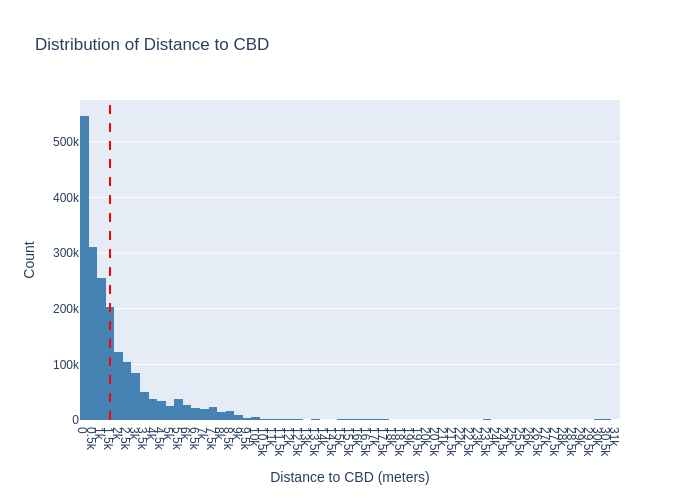

In [182]:
distances = data['distance_to_cbd'].dropna()

fig = px.histogram(
    distances,
    nbins=100,
    title='Distribution of Distance to CBD ',
    labels={'value': 'Distance to CBD (meters)'},
    color_discrete_sequence=['steelblue']
)

fig.update_layout(
    xaxis_title='Distance to CBD (meters)',
    yaxis_title='Count',
    showlegend=False,
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=500
    )
)

fig.add_vline(x=1500, line_dash="dash", line_color="red")

fig.show(renderer='png')


In [183]:
threshold = 1500

data['is_far_from_cbd'] = data.apply(
    lambda row: None if row['in_central_area'] == 1
    else int(row['distance_to_cbd'] > threshold),
    axis=1
)

#### 3.5.7. Geohashing
* Apply geohashing to trip start/end locations (choose and justify precision).
* Categorize geohashed sectors based on average daily trips (red, yellow, gray). Define and justify thresholds.

In [ ]:
# Apply geohashing and categorize sectors

In [205]:
def geohash_to_polygon(geohash):
    lat, lon = pgh.decode(geohash)
    error_lat = pgh.decode_exactly(geohash)[2]
    error_lon = pgh.decode_exactly(geohash)[3]

    min_lat = lat - error_lat
    max_lat = lat + error_lat
    min_lon = lon - error_lon
    max_lon = lon + error_lon

    return box(min_lon, min_lat, max_lon, max_lat)


In [206]:

def create_geohash(lat, lon, precision=6):
    return pgh.encode(lat, lon, precision=precision)


In [207]:
data['geohash_start'] = data.apply(
    lambda row: create_geohash(row['start_lat'], row['start_lng']), axis=1
)
data['geohash_end'] = data.apply(
    lambda row: create_geohash(row['end_lat'], row['end_lng']), axis=1
)

all_geohashes = pd.concat([
    data['geohash_start'],
    data['geohash_end']
]).reset_index(drop=True)

sector_counts = all_geohashes.value_counts().reset_index()
sector_counts.columns = ['geohash', 'total_trips']


geometry = [geohash_to_polygon(g) for g in sector_counts['geohash']]
gdf = gpd.GeoDataFrame(sector_counts, geometry=geometry, crs="EPSG:4326")


red_threshold = gdf['total_trips'].quantile(0.90)
yellow_threshold = gdf['total_trips'].quantile(0.60)

In [208]:
def classify(count):
    if count >= red_threshold:
        return 'Red'
    elif count > yellow_threshold:
        return 'Yellow'
    else:
        return 'Gray'

gdf['category'] = gdf['total_trips'].apply(classify)


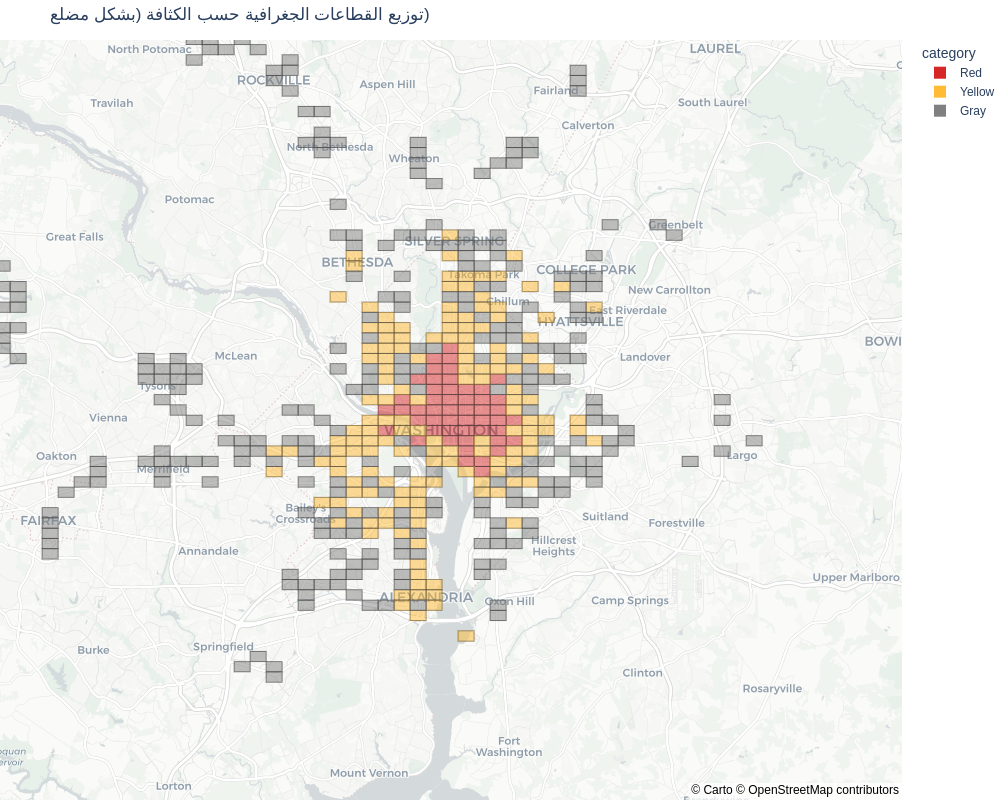

In [210]:
fig = px.choropleth_mapbox(
    gdf,
    geojson=gdf.geometry,
    locations=gdf.index,
    color='category',
    color_discrete_map={
        'Red': '#d62728',     # أحمر داكن
        'Yellow': '#ffbb33',  # أصفر لامع
        'Gray': '#808080'     # رمادي
    },
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 38.90, "lon": -77.03},  # مركز واشنطن دي سي
    opacity=0.5,
    title="توزيع القطاعات الجغرافية حسب الكثافة (بشكل مضلع)",
    hover_data=['total_trips']
)

fig.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    dragmode=False,  # تعطيل التفاعل
    showlegend=True,
    width=1000,
    height=800
)

fig.show(renderer='png')

fig.write_html("geohash_sectors_as_polygons.html")

In [211]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_bus_stop_id,end_EGIS_ID,end_BSTP_LON,end_BSTP_LAT,end_distance_to_end_bstop,in_central_area,distance_to_cbd,is_far_from_cbd,geohash_start,geohash_end
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37.000,2024-05-04 14:37:52.000,14th & G St NW,31238.00,Jefferson Memorial,31249.00,38.90,-77.03,...,6006.00,1307337.00,-77.03,38.89,878.19,1,735.64,NaN,dqcjr1,dqcjnv
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53.000,2024-05-04 15:00:25.000,Jefferson Dr & 14th St SW,31247.00,7th & F St NW / National Portrait Gallery,31232.00,38.89,-77.03,...,4730.00,1307266.00,-77.02,38.90,60.94,1,0.00,NaN,dqcjpp,dqcjr3
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21.000,2024-05-04 15:27:29.000,1st & M St NE,31603.00,4th & M St SW,31108.00,38.91,-77.01,...,4022.00,1311406.00,-77.02,38.88,35.06,0,756.18,0.00,dqcjrd,dqcjpm
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59.000,2024-05-04 14:54:11.000,Jefferson Memorial,31249.00,Hains Point/Buckeye & Ohio Dr SW,31273.00,38.88,-77.04,...,126.00,1395460.00,-77.02,38.88,587.71,0,638.18,0.00,dqcjnv,dqcjpj
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20.000,2024-05-04 19:41:35.000,New Hampshire Ave & T St NW,31229.00,14th & G St NW,31238.00,38.92,-77.04,...,8045.00,1307112.00,-77.03,38.90,39.57,1,0.00,NaN,dqcjqu,dqcjr1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978485,23FA8A5317DDACB1,electric_bike,2024-01-03 16:46:10.000,2024-01-03 16:48:37.000,Grant Circle,31421.00,Park Rd & Holmead Pl NW,31602.00,38.94,-77.02,...,3833.00,1301764.00,-77.03,38.93,117.12,0,2339.29,1.00,dqcjx3,dqcjrp
1978486,2270D408C60E9429,electric_bike,2024-01-03 20:02:17.000,2024-01-03 20:27:12.000,8th & O St NW,31281.00,13th St & New York Ave NW,31227.00,38.91,-77.02,...,9752.00,1307450.00,-77.03,38.90,55.46,1,0.00,NaN,dqcjr7,dqcjr1
1978487,613569D499A23645,electric_bike,2024-09-16 00:31:22.700,2024-09-16 00:51:59.523,The Mall at Prince Georges,32422.00,Baltimore Ave & Van Buren St / Riverdale Park ...,32402.00,38.97,-76.95,...,116.00,1395421.00,-76.94,38.97,94.38,0,9787.59,1.00,dqcm8y,dqcm9n
1978488,79C0AF145131E7AB,electric_bike,2024-09-16 16:49:19.676,2024-09-16 16:57:20.375,Georgia Ave & Morton St NW,31419.00,13th & O St NW/ Logan Circle,31311.00,38.93,-77.02,...,946.00,1307502.00,-77.03,38.91,104.69,0,359.92,0.00,dqcjrr,dqcjr5


#### 3.5.8. Weather Condition Binning
* Bin weather status into 'sunny', 'cloudy', 'rainy'.

In [212]:
# Bin weather conditions

In [213]:
data["conditions"].unique()

array(['Rain, Overcast', 'Partially cloudy', 'Overcast', 'Clear',
       'Rain, Partially cloudy', 'Snow, Rain, Overcast',
       'Snow, Partially cloudy', 'Snow, Rain, Partially cloudy'],
      dtype=object)

In [214]:
def categorize_weather(condition):
    if 'Rain' in condition:
        return 'Rain'
    elif 'Overcast' in condition or 'cloudy' in condition:
        return 'Overcast'
    elif 'Clear' in condition:
        return 'Clear'

data['weather_category'] = data['conditions'].apply(categorize_weather)


#### 3.5.9. Daily Revenue Time Series
* Create a time series of total daily revenue (payment day is trip end date), including weather status.

In [ ]:
# Create daily revenue time series

In [215]:

data['end_date'] = data['ended_at'].dt.date

daily_revenue = data.groupby('end_date')['total_cost'].sum().reset_index()
daily_revenue.rename(columns={'end_date': 'date', 'total_cost': 'daily_revenue'}, inplace=True)

daily_weather = data.groupby('end_date')['weather_category'] \
                      .agg(lambda x: x.mode()[0] if not x.mode().empty else None) \
                      .reset_index()
daily_weather.rename(columns={'end_date': 'date'}, inplace=True)


daily_summary = pd.merge(daily_revenue, daily_weather, on='date', how='left')


daily_trips_count = data.groupby('end_date').size().reset_index(name='trip_count')

daily_trips_count.rename(columns={'end_date': 'date'}, inplace=True)
daily_summary = pd.merge(daily_summary, daily_trips_count, on='date', how='left')


daily_summary['cumulative_revenue'] = daily_summary['daily_revenue'].cumsum()
daily_summary.head(10)

,date,daily_revenue,weather_category,trip_count,cumulative_revenue
0,2024-01-01,6200.27,Rain,1557,6200.27
1,2024-01-02,10585.61,Overcast,2518,16785.88
2,2024-01-03,11472.50,Overcast,2926,28258.38
3,2024-01-04,10886.09,Overcast,2732,39144.47
4,2024-01-05,10471.57,Overcast,2717,49616.04
5,2024-01-06,3988.44,Rain,1009,53604.48
6,2024-01-07,10278.80,Overcast,2664,63883.28
7,2024-01-08,12641.69,Overcast,3203,76524.97
8,2024-01-09,4330.75,Rain,1079,80855.72
9,2024-01-10,13557.72,Rain,3408,94413.44


In [216]:
daily_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                366 non-null    object 
 1   daily_revenue       366 non-null    float64
 2   weather_category    366 non-null    object 
 3   trip_count          366 non-null    int64  
 4   cumulative_revenue  366 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 14.4+ KB


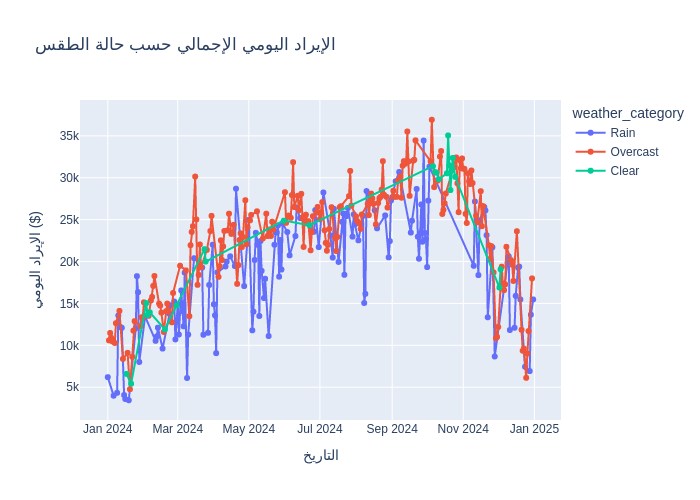

In [217]:
fig = px.line(daily_summary, x='date', y='daily_revenue', color='weather_category',
              title='الإيراد اليومي الإجمالي حسب حالة الطقس',
              labels={'daily_revenue': 'الإيراد اليومي ($)', 'date': 'التاريخ'},
              markers=True)
fig.show(renderer='png')

In [ ]:
fig.write_image("/content/drive/MyDrive/Data Mining Homework/daily_revenue_weather.png")
print("Image saved to Google Drive.")


Image saved to Google Drive.


In [218]:
daily_summary.to_csv('/content/drive/MyDrive/Data Mining Homework/Data/daily_summary.csv', index=False)
data.drop(columns=['end_date'])

#### 3.5.10. Other Custom Features
* Document any other features created to aid exploration or integration.

In [225]:
# Create any other custom features

### 3.6. Final Dataset Check
* Review the merged and augmented dataset for consistency, completeness, and correctness.

In [232]:
# Perform final check on the processed DataFrame

In [ ]:

data.isnull().sum()
data.to_csv('/content/drive/MyDrive/Data Mining Homework/Data/final_data.csv', index=False)

## 4. Exploratory Data Analysis (EDA)

*For each visualization, provide an interpretation of what the chart shows and any insights derived in a markdown cell below the code cell producing the chart.*

### 4.1. Bike and Station Analysis

#### 4.1.1. Top 5 busiest start stations (Bar chart).

*(Interpretation for 4.1.1)*

#### 4.1.2. Trip distribution by bike type and subscription type (Bar chart).

*(Interpretation for 4.1.2)*

#### 4.1.3. Trip distribution by bike type and subscription type for the top 5 start stations (Sunburst chart).

*(Interpretation for 4.1.3)*

#### 4.1.4. Distribution of bike station capacities (Histogram).

*(Interpretation for 4.1.4)*

#### 4.1.5. Trip distribution by start and end station capacity category (Bar chart).

*(Interpretation for 4.1.5)*

### 4.2. Trip Duration Analysis

#### 4.2.1. Distribution of trip duration in minutes (Histogram, choose appropriate bins).

In [1]:
q25, q75 = data['duration_minutes'].quantile([0.25, 0.75])
iqr = q75 - q25
bin_width = 2 * iqr / (len(data['duration_minutes'].dropna()) ** (1/3))
bins_count = int((data['duration_minutes'].max() - data['duration_minutes'].min()) / bin_width)
print(f"Freedman-Diaconis: {bins_count} bins")

NameError: name 'data' is not defined

In [243]:
fig = px.histogram(
    data,
    x='duration_minutes',
    nbins=150,  # عدد الأشرطة
    title='توزيع مدة الرحلة بالدقائق',
    labels={'duration_minutes': 'مدة الرحلة بالدقائق', 'count': 'عدد الرحلات'}
)

fig.update_layout(
    xaxis_title='مدة الرحلة بالدقائق',
    yaxis_title='عدد الرحلات'
)

fig.show(renderers="png")


*(Interpretation for 4.2.1)*

#### 4.2.2. Trip duration distribution by bike type (Box plot).

In [ ]:
# prompt: قم برسم مخطط صندوقي Box يعرض توزع مدة الرحلة بالدقائق حسب نوع الدراجة

fig = px.box(
    data,
    x='rideable_type',
    y='duration_minutes',
    title='توزيع مدة الرحلة بالدقائق حسب نوع الدراجة',
    labels={'rideable_type': 'نوع الدراجة', 'duration_minutes': 'مدة الرحلة بالدقائق'}
)

fig.update_layout(
    xaxis_title='نوع الدراجة',
    yaxis_title='مدة الرحلة بالدقائق'
)

fig.show(renderers="png")

*(Interpretation for 4.2.2)*

#### 4.2.3. Trip duration distribution by subscription type (Box plot).

In [ ]:
# prompt: قم برسم مخطط صندوقي Box يعرض توزع مدة الرحلة بالدقائق حسب نوع
# االشتراك

fig = px.box(
    data,
    x='member_casual',
    y='duration_minutes',
    title='توزيع مدة الرحلة بالدقائق حسب نوع االشتراك',
    labels={'member_casual': 'نوع االشتراك', 'duration_minutes': 'مدة الرحلة بالدقائق'}
)

fig.update_layout(
    xaxis_title='نوع االشتراك',
    yaxis_title='مدة الرحلة بالدقائق'
)

fig.show(renderers="png")

*(Interpretation for 4.2.3)*

#### 4.2.4. Map of stations showing trips exceeding one day (Folium map, point size based on count).

In [ ]:
# Ensure station coordinates are in EPSG:4326 for Folium

In [ ]:
# prompt: قم بتعيين مجموعة الرحالت التي تجاوزت مدتها اليوم الواحد، ثم ارسم محطات
# الدراجات ضمن خريطة تعرض واشنطن العاصمة محدًدا حجم النقطة تِب ًعا لعدد
# الرحالت )تجاوزت مدة يوم( التي استقبلتها )مجموع االنطالق واالنتهاء(

# Filter trips longer than one day (86400 seconds or 1440 minutes)
long_trips = data[data['duration_minutes'] > 1440].copy()

# Aggregate the number of long trips per station (start and end)
start_station_counts = long_trips['start_station_id'].value_counts().reset_index()
start_station_counts.columns = ['station_id', 'start_trip_count']

end_station_counts = long_trips['end_station_id'].value_counts().reset_index()
end_station_counts.columns = ['station_id', 'end_trip_count']

# Merge the counts and the stations information
station_long_trip_counts = stations_df[['id', 'NAME', 'LATITUDE', 'LONGITUDE']].copy()
station_long_trip_counts = station_long_trip_counts.merge(start_station_counts, left_on='id', right_on='station_id', how='left')
station_long_trip_counts = station_long_trip_counts.merge(end_station_counts, left_on='id', right_on='station_id', how='left')

# Fill NaN counts with 0
station_long_trip_counts['start_trip_count'].fillna(0, inplace=True)
station_long_trip_counts['end_trip_count'].fillna(0, inplace=True)

# Calculate the total long trips received by each station
station_long_trip_counts['total_long_trip_count'] = station_long_trip_counts['start_trip_count'] + station_long_trip_counts['end_trip_count']

# Filter stations that had at least one long trip
stations_with_long_trips = station_long_trip_counts[station_long_trip_counts['total_long_trip_count'] > 0]

# Create a Folium map centered around Washington D.C.
dc_lat, dc_lon = 38.9072, -77.0369
m = folium.Map(location=[dc_lat, dc_lon], zoom_start=12)

# Add points for each station with long trips, sizing based on total count
for idx, row in stations_with_long_trips.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=math.sqrt(row['total_long_trip_count']) * 2, # Adjust scaling factor as needed
        popup=f"Station: {row['NAME']}<br>Total Long Trips: {int(row['total_long_trip_count'])}",
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m

*(Interpretation for 4.2.4)*

### 4.3. Financial Analysis

#### 4.3.1. Distribution of trip cost (Histogram and Box plot in the same figure).

*(Interpretation for 4.3.1)*

#### 4.3.2. Trip cost vs. trip duration (Scatter plot with trend line).

*(Interpretation for 4.3.2)*

#### 4.3.3. Trip cost vs. temperature, colored by bike type (Scatter plot).

*(Interpretation for 4.3.3)*

#### 4.3.4. Time series of total daily and weekly revenue (Line chart).

*(Interpretation for 4.3.4)*

#### 4.3.5. Time series of average monthly revenue (Line chart).

*(Interpretation for 4.3.5)*

### 4.4. Spatial Analysis of Bike Trips

#### 4.4.1. Geographic heatmap of trip counts per residential area. Total trips outside residential areas.

In [ ]:
# Use Folium or other permitted library for heatmaps on geographic areas

*(Interpretation for 4.4.1)*

#### 4.4.2. Distribution of geohash sector categories (red, yellow, gray) (Bar chart).

*(Interpretation for 4.4.2)*

#### 4.4.3. Distribution of distance to CBD, nearest metro, nearest bus stop (Histograms).

*(Interpretation for 4.4.3)*

#### 4.4.4. Trip distribution: entirely within CBD vs. outside CBD (Bar chart).

*(Interpretation for 4.4.4)*

#### 4.4.5. Distribution of trips passing through CBD by bike type and subscription type (Bar chart).

*(Interpretation for 4.4.5)*

#### 4.4.6. Chi-square test: Association between distance-to-CBD category and subscription type.

In [ ]:
# Perform Chi-square test using scipy.stats.chi2_contingency

*(Interpretation for 4.4.6)*

### 4.5. Weather Impact Analysis

#### 4.5.1. Daily average temperature, wind speed, and humidity (Line chart).

*(Interpretation for 4.5.1)*

#### 4.5.2. Daily revenue by weather condition (sunny, cloudy, rainy) (Box plot).

*(Interpretation for 4.5.2)*

#### 4.5.3. Linear correlation between temperature, humidity, and daily revenue (Correlation matrix/heatmap, scatter plots).

*(Interpretation for 4.5.3)*

#### 4.5.4. Chi-square test: Association between weather condition and bike type.

*(Interpretation for 4.5.4)*

### 4.6. Handling Outliers for Visualizations
* Discuss any steps taken to handle outliers that might distort visualizations (e.g., capping values, log transformations for plotting).

In [ ]:
# Show code for outlier handling if applicable (e.g. before plotting certain distributions)

## 5. Pattern Discovery

### 5.1. Time Series Analysis (Revenue Forecasting)

#### 5.1.1. Verify Time Series Properties
* Check for regular intervals, missing dates in the daily revenue series. Resample or fill if necessary.

In [ ]:
daily_summary=pd.read_csv('/content/drive/MyDrive/Data Mining Homework/Data/daily_summary.csv')
daily_summary

,date,daily_revenue,weather_category,trip_count,cumulative_revenue
0,2024-01-01,6200.27,Rain,1557,6200.27
1,2024-01-02,10585.61,Overcast,2518,16785.88
2,2024-01-03,11472.50,Overcast,2926,28258.38
3,2024-01-04,10886.09,Overcast,2732,39144.47
4,2024-01-05,10471.57,Overcast,2717,49616.04
...,...,...,...,...,...
361,2024-12-27,11705.38,Overcast,2930,7791102.68
362,2024-12-28,6921.95,Rain,1775,7798024.63
363,2024-12-29,13652.95,Rain,3386,7811677.58
364,2024-12-30,17987.38,Overcast,4418,7829664.96


#### 5.1.2. Baseline Model
* Develop a simple baseline for forecasting revenue for the next 10 days (e.g., naive forecast, moving average).

#### 5.1.3. Prophet Modeling (or other time series model)
* Prepare data for Prophet (ds, y columns).
* Initialize and fit Prophet model.
* Make future dataframe and predict.
* Plot forecast components (trend, seasonality).
* Perform hyperparameter tuning (if applicable, or discuss potential tuning strategies).

In [ ]:
# Example with Prophet (ensure Prophet is installed and imported)
# from prophet import Prophet
# model = Prophet()
# model.fit(daily_revenue_prophet_df) # df should have 'ds' and 'y' columns
# future = model.make_future_dataframe(periods=10)
# forecast = model.predict(future)
# fig1 = model.plot(forecast)
# fig2 = model.plot_components(forecast)

#### 5.1.4. Model Comparison
* Evaluate baseline and Prophet models using appropriate metrics (MAE, MSE, RMSE, MAPE).

#### 5.1.5. Interpretation of Time Series Components
* Discuss insights from trend, weekly/yearly seasonality.

### 5.2. General Usage Pattern Analysis (Clustering)

#### 5.2.1. Data Sampling
* If the dataset is too large, sample it. Justify the sampling method and size.

#### 5.2.2. Feature Selection/Scaling
* Select relevant features for clustering. Scale numerical features (e.g., StandardScaler).

#### 5.2.3. Clustering Algorithms
* Apply 2-3 clustering algorithms (e.g., K-Means, DBSCAN, Agglomerative Clustering).
* For K-Means, determine optimal K (e.g., Elbow method, Silhouette analysis).

In [ ]:
# K-Means Example
# inertia = []
# silhouette_scores = []
# K = range(2, 11)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(scaled_features_df)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

# Plot Elbow method and Silhouette scores

# Apply chosen K to K-Means
# Apply DBSCAN, Agglomerative Clustering

#### 5.2.4. Cluster Profiling and Comparison
* Describe the characteristics of each cluster (e.g., average trip duration, common start/end geohashes, preferred bike type, member type distribution within clusters).
* Compare the results from different algorithms.

#### 5.2.5. Post-processing and Feature Importance (for best model)
* Discuss any post-processing steps.
* Identify key features influencing the clustering for the best performing algorithm (e.g., by analyzing cluster centroids for K-Means, or feature distributions per cluster).
* Provide your opinion on the findings.

## 6. Secret Mission (Optional Bonus Exploration)

* This section is for any additional analyses, visualizations, or insights discovered beyond the specific requirements.
* Document any creative explorations or deeper dives into the data.
* Use any dataset as needed.
* Focus on clean, readable, and reusable code.
* Emphasize storytelling with data.

## 7. Documentation and Conclusion

### 7.1. Summary of Findings
* Briefly summarize the key insights derived from each major section (Preprocessing, EDA, Pattern Discovery).

### 7.2. Challenges Encountered
* Discuss any significant challenges faced during the project (e.g., data quality issues, computational limitations, complex feature engineering).

### 7.3. Solutions Implemented
* Describe how these challenges were addressed.

### 7.4. Future Work/Recommendations
* Suggest potential future analyses or actions based on the project's findings.

### 7.5. Final Conclusion
* Overall concluding remarks about the bike-sharing patterns in Washington D.C.

## Appendix (If Needed)

* Detailed explanations of complex calculations.
* Code snippets for reusable functions (if not defined inline).

---
**General Notebook Guidelines (as per project document):**

* Use Python in a Jupyter Notebook (Colab environment).
* Adhere to the allowed libraries.
* Ensure all cells are executed and results are displayed before submission.
* Make charts static images for final submission if Plotly interactive charts cause issues (`fig.show(renderer='png')` or `fig.to_image(format='png')`).
* No screenshots or raw code dumps in the final *written report* (this notebook is the code artifact).
* Write clean, readable, and reusable code.
* Use Pandas pipes where appropriate.
* Explain every chart and statistical test result.
* Be mindful of academic integrity and citation if external code/ideas are used (though the project emphasizes original work).
* Keep the notebook organized and avoid excessively long print outputs or error messages.